# **Imputation recommendation machine learning model**

The imputation algorithm "reccomendation" multiclass machine learning model is the key element in the pipline tool. This model will be trained to take in a set of pre-defined metafeatures (including the feature for which missing data points need imputation) relating to a dataset and return the imputation algorithm that is best used to replace the missing data points in the dataset. Although the model is called a "reccomedation" tool it is a classification task and thus will be a classification model.

In this file the model will be trained, tested and optimised. It will be trained and tested on the results (statistics) obtained from running the imputation algorithms on our stored datasets, these results include the file (for which the metafeatures can be extracted for input) and the name of the imputation algorithm which gave the best estimated imputed values. When testing / validating the model we will be aiming for 70% as per requirement 1.2 of section 3.4 on artefact MoSCoW requirements, testing / validation will be performed visual through the use of line graphs and confusion matrixes aswell as the functional use case testing that is performed. Finally in order to optimise the model various experiment will be performed where the parameters of the model such as the optimiser or loss function to determine the optimal configuration for the model.

# Mounting the Google drive

This allows us to access all the data we store in this project as well at the file system

In [ ]:
# Need to mount drive to access and save files that store model stats, figures, etc
from google.colab import drive
import os


# Mount the drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Final_year_project") # Path of reference for imports
folder = os.path.join("/content/drive/MyDrive/Final_year_project") # Reference for future use when importing / exporting files

# View files in the current working directory
!ls

Mounted at /content/drive
data
datasets
getImputationModelsStats.ipynb
getMissingData.ipynb
imputationRecommendationModel.ipynb
imputationRecommendationModelRandomForest.ipynb
machine_learning_model
pipeline.ipynb
random_forest_machine_learning_model
root


# Imports and installs

This section import and/or installs all neccessary python libraries

In [ ]:
# pip installs
!pip install -U kaleido
!pip install lime
!pip install shap
!pip install visualkeras
!pip install imbalanced-learn
!pip install tf-explain
!pip install tensorflow


# Imports
from datetime import datetime
from google.colab import drive
from pathlib import Path
from tensorflow.keras import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.initializers import GlorotUniform, HeNormal, RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import (
    Dense,
    ZeroPadding2D,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Input,
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    Activation,
    AveragePooling2D,
    Add,
    Resizing,
    RandomRotation,
    BatchNormalization
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from prettytable import PrettyTable
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from seaborn import heatmap
from tf_explain.core.grad_cam import GradCAM
from lime import lime_image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

import json
import pandas as pd
import time
import numpy as np
import random
import os
import shap
import matplotlib.pyplot as plt
import visualkeras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import fnmatch
import gc
import sys
import itertools
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ad0d2ef7dcb6e29a987444585032d55fa9a6b6a69f2837deab59c2f84ca76d53
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00


# Visualisation functions

This section contains functions that can be used to visualise the results of training and validating the machine learning model

In [ ]:
"""CSV file reading"""


# Get csv files data and generate titles
def get_csv_files(experiment_stats_folder, prev_experiment_stats_path):
  iteration_data = []
  csv_files = [file for file in os.listdir(experiment_stats_folder) if file.endswith('.csv')]
  csv_files.sort()


  # Loop through csv files and put data into dataframe + generate titles for saving figure based of csv data
  for index in range(0, len(csv_files)):
    csv_file_path = os.path.join(experiment_stats_folder, csv_files[index])
    iteration_data.append(pd.read_csv((csv_file_path)))


  iteration_data.append(pd.read_csv(prev_experiment_stats_path))


  return iteration_data




"""Validation training comparison figures"""
def graph_metric_trainingValidationData(stats_data, title, save_fig_folder, filename, training_metric, validation_metric, metric_title):
  training_metric = np.nan_to_num(np.array(stats_data[training_metric]), nan=0.0, posinf=1.0, neginf=1.0)
  validation_metric = np.nan_to_num(np.array(stats_data[validation_metric]), nan=0.0, posinf=1.0, neginf=1.0)
  epochs = np.array(stats_data['epoch'])

  # Create curve on graph
  training_metric_epochs_Spline = make_interp_spline(epochs, training_metric)
  epochs_ = np.linspace(epochs.min(), epochs.max(), 500) # Generate more data points in the interval

  # Returns evenly spaced numbers over a specified interval.
  training_metric = training_metric_epochs_Spline(epochs_)

  # Create curve on graph
  validation_metric_epochs_Spline = make_interp_spline(epochs, validation_metric)

  # Returns evenly spaced numbers over a specified interval.
  validation_metric = validation_metric_epochs_Spline(epochs_)

  # Configure figure image
  plt.figure(figsize=(10, 5), layout='constrained')
  plt.plot(epochs_, training_metric, label='training_data')  # Plot some data on the (implicit) Axes.
  plt.plot(epochs_, validation_metric, label='validation_data')  # etc.
  plt.xlabel('Epochs')
  plt.ylabel(metric_title)
  plt.title(title)
  plt.legend()


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    plt.savefig(os.path.join(save_fig_folder, filename))


# Figure comparing the accuracy of the validation and training datasets
def graph_accuracy_trainingValidationData(stats_data, title, save_fig_folder, filename = "training_validation_accuracy_plot.png"):
  graph_metric_trainingValidationData(stats_data, title, save_fig_folder, filename, "accuracy", "val_accuracy", "Accuracy")




"""Iteration comparison figures"""
def graph_trainingData_iteration_metric_comparison(stats_data_list, sets_titles, title, save_fig_folder, filename, metric, metric_title, plot_postfix):

  # Create figure
  plt.figure(figsize=(10, 5), layout='constrained')


  # Loop through a list of dataframes and get the training set data for each iteration:
  for index in range(0, len(stats_data_list)):

    # Get data the index is required for
    stats_data = stats_data_list[index]
    data_metric = np.nan_to_num(np.array(stats_data[metric]), nan=0.0, posinf=1.0, neginf=1.0)
    epochs = np.array(stats_data['epoch'])

    # Create curve on graph
    data_metric_epochs_Spline = make_interp_spline(epochs, data_metric)

    # Returns evenly spaced numbers over a specified interval.
    epochs_ = np.linspace(epochs.min(), epochs.max(), 500) # Generate more data points in the interval
    data_metric = data_metric_epochs_Spline(epochs_)

    plt.plot(epochs_, data_metric, label=f"{sets_titles[index]}_{plot_postfix}")  # Plot some data on the (implicit) Axes.

  plt.xlabel('Epochs')
  plt.ylabel(metric_title)
  plt.title(title)
  plt.legend()


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    plt.savefig(os.path.join(save_fig_folder, filename))


# Figure comparing the accuracy of multiple training sets
def graph_trainingData_iteration_accuracy_comparison(stats_data_list, sets_titles, title, save_fig_folder, filename="training_sets_accuracy_plot.png"):
  graph_trainingData_iteration_metric_comparison(stats_data_list, sets_titles, title, save_fig_folder, filename, "accuracy", "Accuracy", "training_data")


# Figure comparing the accuracy of multiple validation sets
def graph_validationData_iteration_accuracy_comparison(stats_data_list, sets_titles, title, save_fig_folder, filename="validation_sets_accuracy_plot.png"):
  graph_trainingData_iteration_metric_comparison(stats_data_list, sets_titles, title, save_fig_folder, filename, "val_accuracy", "Loss", "validation_data")




"""Validation training stats table figure"""
# Table figure
def graph_iterations_final_stats(iteration_data, iteration_titels, main_column, save_fig_folder, epochs=10):
  iterations_accuracy = iterations_loss = iterations_val_accuracy = iterations_val_loss = []
  iterations_dict = []


  # Get the stats final epochs data point for the current iteration
  index = 0


  for iteration in iteration_data:
    iterations_dict.append(
        {
            'Title': iteration_titels[index],
            'Training Accuracy': np.nan_to_num(iteration["accuracy"][epochs-1], nan=0.0, posinf=1.0, neginf=1.0),
            'Validation Accuracy': np.nan_to_num(iteration["val_accuracy"][epochs-1], nan=0.0, posinf=1.0, neginf=1.0)
        }
    )

    index += 1


  iterations_df = pd.json_normalize(iterations_dict)

  fig = go.Figure(
      data=[
          go.Table(
              header=dict(
                  values=list(iterations_df.columns),
                  fill_color='paleturquoise',
                  align='left'
              ),
              cells=dict(
                  values=[iterations_df[col] for col in iterations_df.columns],
                  fill_color='lavender',
                  align='left'
              )
          )
      ]
  )

  fig.update_layout(width=800)

  fig.show()  # Opens in browser


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    fig.write_image(os.path.join(save_fig_folder, "iterations_final_stats_table.png"))




"""Confusion matrix figure"""
# Function to make confusion matrix given current model and validation dataset
def make_confusion_matrix(model, validation_dataset, class_names, save_fig_folder, image_label="confusion_matrix.png", title="Confusion matrix"):

  # Set up lists to record predictions and correct results
  predictions = []
  labels = []
  prediction_for_batches = []
  class_indices = [index for index in range(0, len(class_names))]


  # Loop through image batches to generate predictions
  for image_batch, label_batch in validation_dataset:
      prediction_batch = model.predict(image_batch, verbose=0)
      predictions_flattened = np.argmax(prediction_batch, axis=1)

      predictions.extend(predictions_flattened)
      prediction_for_batches.extend(prediction_batch)

      labels.extend(np.argmax(label_batch, axis=1) if len(label_batch.shape) > 1 else label_batch)


  predictions = np.array(predictions)
  labels = np.array(labels)
  prediction_for_batches = np.array(prediction_for_batches)

  validation_labels_binary = label_binarize(labels, classes=class_indices)

  # Create visualisation of confusion matrix
  conf_matrix = confusion_matrix(predictions, labels)
  plt.figure(figsize=(10, 10))
  plt.title(title)
  heatmap(conf_matrix, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='coolwarm', fmt='g')
  plt.show()


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    plt.savefig(os.path.join(save_fig_folder, image_label))


# Load Keras
This section contains functionality to load .keras files back into models

In [ ]:
# Returns a list of all keras files in a directory loaded into models
def load_keras_models(model_path):
  keras_files = [file for file in os.listdir(model_path) if file.endswith('.keras')]
  keras_files.sort()
  models = []


  # Loop through csv files and put data into dataframe + generate titles for saving figure based of keras data
  for index in range(0, len(keras_files)):
    keras_file_path = model_path + "/" + keras_files[index]
    current_model = load_model(keras_file_path) # Load model from keras configuration file
    models.append(current_model)


  return models


# Runs all a directories models loaded from keras files into a confusion matrix
def load_keras_confusion(model_path, validation_dataset, class_names, model_titels, save_fig_folder):
  models = load_keras_models(model_path)
  models_labels = [f"iteration{index+1}_confusion_matrix.png" for index in range(0, len(models))] # models_labels is for file saving, model_titels is for the figure title


  for index in range(0, len(models)):
    make_confusion_matrix(models[index], validation_dataset, class_names, save_fig_folder, models_labels[index], model_titels[index])

# Establishing variables

In this section we simply establish all global peices of information we will need for future use

In [ ]:
# Specify the paths to download the datasets
download_path = './datasets'
original_path = "./data/Original"
mcar_path = "./data/MCAR"
mar_path = "./data/MAR"
mnar_path = "./data/MNAR"
imputation_stats_folder = "imputation_stats"
imputation_stats_file = "imputation_stats.json"


# Deault locations for image / stats saving
original_stats_folder = "original_model_stats"
original_image_folder = "original_model_images"

machine_learning_folder = "machine_learning_model"

model_stats_file = "original_model_stats.csv"
model_image_file = "original_model_image.keras"


# Set model parameters as defualt in initialisation for consistency
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 16
epochs = 10
num_input = 41
class_names = ["Mean / Mode / Median Imputation",
                   "LOCF Imputation",
                   "NOCF Imputation",
                   "Regression Imputation",
                   "MICE imputation",
                   "MissForest Imputation",
                   "Bayesian Imputation",
                   "kNN Imputation"]
num_classes = len(class_names)


# Create imputation algorithm lookup for future use - dictionary is from imputation stats generation notebook
imputation_scores_lookup = {
    0: "Mean / Mode / Median Imputation",
    1: "LOCF Imputation",
    2: "NOCF Imputation",
    3: "Regression Imputation",
    4: "MICE imputation",
    5: "MissForest Imputation",
    6: "Bayesian Imputation",
    7: "kNN Imputation"
}
imputation_scores_lookup_inverse = {value: key for key, value in imputation_scores_lookup.items()}

# Create a lookup table from the imputation algorithm lookup dictionary
lookup_imputation_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(tf.constant(list(imputation_scores_lookup_inverse.keys())), tf.constant(list(imputation_scores_lookup_inverse.values()))),
    default_value=-1
)

# Create an inverse lookup table from the imputation algorithm lookup dictionary
lookup_imputation_table_inverse = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(tf.constant(list(imputation_scores_lookup.keys())), tf.constant(list(imputation_scores_lookup.values()))),
    default_value='unknown'
)

is_datasets = True

# Model architecture

In this section we create the function to initialise the architecture and parameters for the multiclass classification imputation reccomendation neural network (machine learning model) This function also contains parameters that help to adjust the architecture to perform experiments on the model whose assessment can be used to further optimise the model (this will come up in the experiments section of the notebook)

In [ ]:
# Define model Architecture

# CNN architecture definition function
def imputation_recomendation_model(
    classes = 8,
    initializer = GlorotUniform(seed=0),
    dropout_rate = 0.5,
    extra_layer_switches = [False, False, False, False, False],
    has_augment = False,
    augment_prob = 0
):


  # Determine weather to implement random image augmentation
  if has_augment and random.uniform(0, 1) < augment_prob:
    print("Data augmented")



  # Model layer 1 - input:
  X_input = Input(shape=(40,))

  X = Dense(80, activation='leaky_relu', name='layer1', kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001))(X_input)

  # Dropout sub section
  X = Dropout(dropout_rate)(X)


  # Determine weather to turn on extra layer
  if extra_layer_switches[0]:
    X = Dense(100, activation='leaky_relu', name='extra_layer1', kernel_initializer = initializer)(X)


  # Determine weather to turn on extra layer
  if extra_layer_switches[1]:
    X = Dense(120, activation='leaky_relu', name='extra_layer2', kernel_initializer = initializer)(X)


  # X = BatchNormalization(axis=-1)(X)




  # Model layer 2:
  X = Dense(120, activation='leaky_relu', name='layer2', kernel_initializer = initializer)(X)

  # Dropout layer
  X = Dropout(dropout_rate)(X)


  # Determine weather to turn on extra layer
  if extra_layer_switches[2]:
    X = Dense(100, activation='leaky_relu', name='extra_layer3', kernel_initializer = initializer)(X)


  # X = BatchNormalization(axis=-1)(X)




  # Model layer 3
  X = Dense(80, activation='leaky_relu', name='layer3', kernel_initializer = initializer)(X)


  # Determine weather to turn on extra layer
  if extra_layer_switches[3]:
    X = Dense(40, activation='leaky_relu', name='extra_layer4', kernel_initializer = initializer)(X)


  # X = BatchNormalization(axis=-1)(X)




  # Model layer 4
  X = Dense(40, activation='leaky_relu', name='layer4', kernel_initializer = initializer)(X)


  # Determine weather to turn on extra layer
  if extra_layer_switches[4]:
    X = Dense(20, activation='leaky_relu', name='extra_layer5', kernel_initializer = initializer)(X)


  # X = BatchNormalization(axis=-1)(X)




  # Model layer 5 - output:
  X = Dense(classes, activation='softmax', name='layer5', kernel_initializer = initializer)(X)




  # Finalise model creation:
  return Model(inputs = X_input, outputs = X, name='imputation_recomendation_model')

# Model configuration
Here we create the functionality to configure the models architecture and the callback funtions that will be used to log the the models image and stats from testing and training

In [ ]:
# Function to configure model with parameters for re-usability - initialise default parameters
def configure_model(
    learning_rate = 0.005,
    classes = 8,
    loss_function = "categorical_crossentropy",
    optimizer = SGD(learning_rate = 0.005),
    initializer = GlorotUniform(seed = 0),
    dropout_rate = 0.5,
    extra_layer_switches = [False, False, False, False, False],
    has_augment = False,
    augment_prob = 0
  ):

  # Configure the model
  model = imputation_recomendation_model(
      classes = classes,
      initializer = initializer,
      dropout_rate = dropout_rate,
      extra_layer_switches = extra_layer_switches,
      has_augment = has_augment,
      augment_prob = augment_prob
  )

  # Compile the model with the parameters
  model.compile(
      optimizer = optimizer, # Replace in later experiments
      loss = loss_function,
      metrics=["accuracy"],
  )


  return model




# Function to configure callbacks with parameters for re-usability
def configure_callbacks(
    model_image_save_file,
    model_stats_save_file):


  return [
        ModelCheckpoint(
            model_image_save_file,
            monitor="accuracy",
            mode="max",
            save_weights_only=False,
            save_best_only=True,
        ),

        CSVLogger(
            model_stats_save_file,
            append=False,
        ),
    ]


# Model training

In this section we train, test / validation and evaluate the model in its initial / original state (saving the stats of the assessment as well as the model image) This is done so that we have something to compare the future model configurations against when we start performing optimisation experiments.

In [ ]:
# Enable egear execution
tf.compat.v1.enable_eager_execution()

# Get the inital data needed for training
train_data, validation_data, _ = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Create folders if they don't exist
original_stats_path = os.path.join(machine_learning_folder, original_stats_folder)
original_image_path = os.path.join(machine_learning_folder, original_image_folder)


if not os.path.exists(original_stats_path):
    os.makedirs(original_stats_path)
    print(f"Folder '{original_stats_path}' created.")


if not os.path.exists(original_image_path):
    os.makedirs(original_image_path)
    print(f"Folder '{original_image_path}' created.")


# Initalise model and callbacks with default parameters
optimizer = SGD(learning_rate=learning_rate)
model = configure_model(
    learning_rate = learning_rate,
    classes = num_classes,
    loss_function = loss_function,
    optimizer = optimizer,
    initializer = initializer,
    dropout_rate = dropout_rate,
    extra_layer_switches = extra_layer_switches,
    has_augment = has_augment,
    augment_prob = augment_prob
)

callbacks = configure_callbacks(
    model_image_save_file = os.path.join(original_image_path, model_image_file),
    model_stats_save_file = os.path.join(original_stats_path, model_stats_file)
)


if is_datasets:
  history = model.fit(
      train_data,
      validation_data = validation_data,
      batch_size = batch_size,
      epochs = epochs,
      callbacks = callbacks,
      verbose=1
  )

else:
  history = model.fit(
      train_data[0],
      train_data[1],
      validation_data = (validation_data[0], validation_data[1]), # (X_val, y_val)
      batch_size = batch_size,
      epochs = epochs,
      callbacks = callbacks,
      verbose=1
  )

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2550 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2704 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2859 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2740 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2857 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2790 - loss: na

# Model Analysis

In this section we perform further assessment of the inital model by visualising the stats returned from the training and testing of the initial model

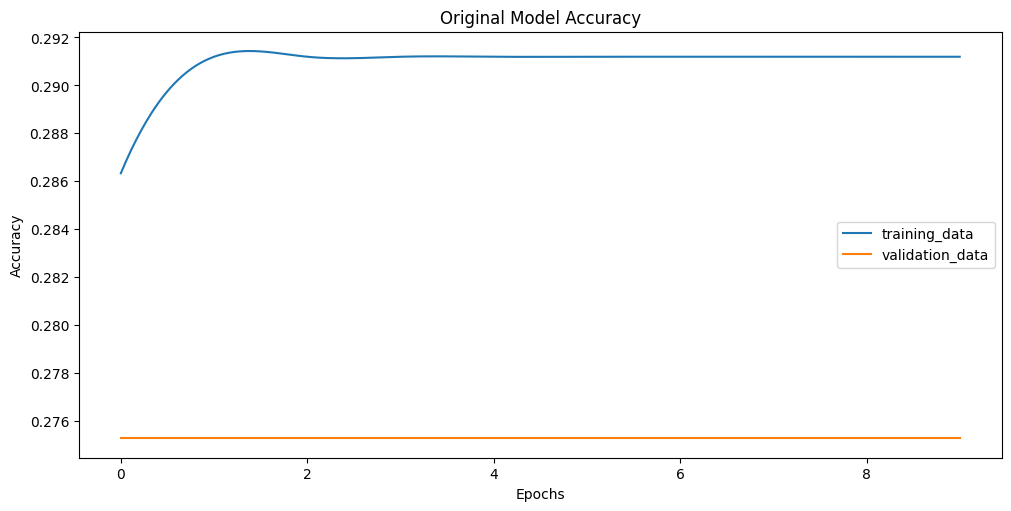

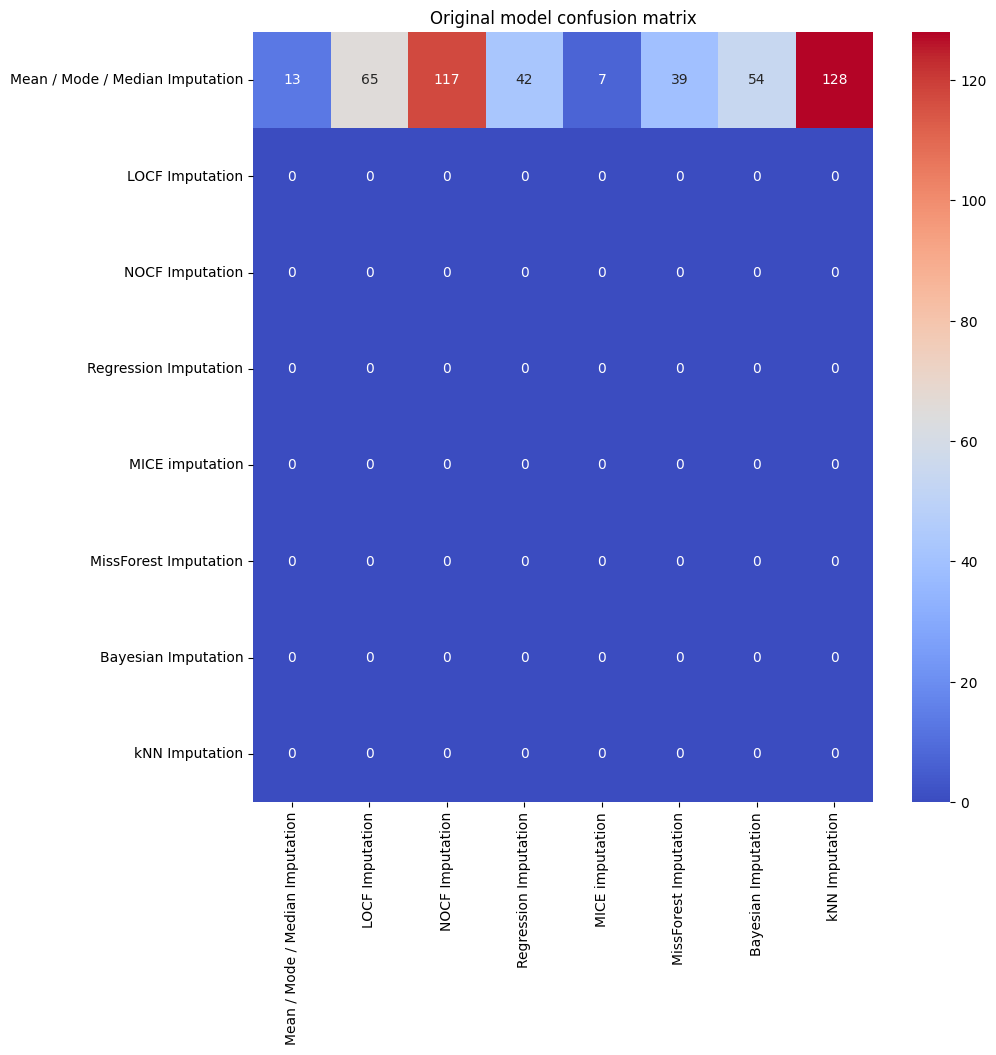

<Figure size 640x480 with 0 Axes>

In [ ]:
# Put the original model data into a graph
csv_stats = pd.read_csv(os.path.join(machine_learning_folder, original_stats_folder, model_stats_file))

graph_accuracy_trainingValidationData(csv_stats, "Original Model Accuracy", os.path.join(machine_learning_folder, original_stats_folder))

#graph_loss_trainingValidationData(csv_stats, "Original Model Loss", os.path.join(machine_learning_folder, original_stats_folder))


# Initialise class names and confusion matrix
if is_datasets:
  make_confusion_matrix(model, validation_data, class_names, os.path.join(machine_learning_folder, original_stats_folder), "confusion_matrix.png", "Original model confusion matrix")

else:
  make_confusion_matrix(model, [(validation_data[0], validation_data[1])], class_names, os.path.join(machine_learning_folder, original_stats_folder), "confusion_matrix.png", "Original model confusion matrix")

# Model Results

The initial model performs very decently usually giving an validation accuracy of 0.2753 for tensorflow dataset data and 0.2706 for numpy datasets. Because of the increase in accuracy from here we load data into tensorflow datasets. It is likely that the class imbalance in the data is causing the reduced accuracy issues and we attempt to address this in three different approaches in the following sections

# **First Experiments**

In this section we experiment with using class weighting to reduce the effect of the imbalance in the data when training in an attempt to increase the accuracy of the model

## First Loading the datasets

In this section we create a new function to load the statistics file from each missingness mechansim folder and calculating a class weighting lookp to help prevent imbalance in the data

In [ ]:
def load_dataset(download_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size):


  # Load stats file
  if not os.path.exists(os.path.join(download_path, imputation_stats_folder, imputation_stats_file)):


    return None


  # Load dataset into DataFrame
  with open(os.path.join(download_path, imputation_stats_folder, imputation_stats_file), 'r') as json_data:
    imputation_stats_JSON = json.loads(json_data.read())
    imputation_stats = pd.json_normalize(imputation_stats_JSON)


  # Seperate into data and labels
  imputation_stats_algorithms_labels = np.array(imputation_stats["optimal_imputation_algorithm"])
  imputation_stats.drop("optimal_imputation_algorithm", axis=1, inplace=True)
  imputation_stats_metafeatures = np.array([row.tolist() for _, row in imputation_stats.iterrows()])

  # One-hot encode labels
  imputation_stats_algorithms_string_labels = tf.constant(imputation_stats_algorithms_labels)
  imputation_stats_algorithms_labels_enocded = lookup_imputation_table.lookup(imputation_stats_algorithms_string_labels)
  imputation_stats_algorithms_labels_enocded = np.array(to_categorical(imputation_stats_algorithms_labels_enocded, num_classes))

  # Split into training and validation datasets
  X_train, X_test, y_train, y_test = train_test_split(imputation_stats_metafeatures, imputation_stats_algorithms_labels_enocded, test_size=0.2, random_state=42)

  # shuffle the data
  perm_train = np.random.permutation(len(X_train))
  X_train = X_train[perm_train]
  y_train = y_train[perm_train]

  perm_test = np.random.permutation(len(X_test))
  X_test = X_test[perm_test]
  y_test = y_test[perm_test]

  # Clean the data
  X_train = np.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=1.0)
  X_test = np.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=1.0)
  y_train = np.nan_to_num(y_train, nan=0.0, posinf=1.0, neginf=1.0)
  y_test = np.nan_to_num(y_test, nan=0.0, posinf=1.0, neginf=1.0)

  training_datasets = (X_train, y_train) if not in_datasets else tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
  validation_datasets = (X_test, y_test) if not in_datasets else tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1000).batch(batch_size)


  return training_datasets, validation_datasets




def load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size):


  # Load datasets for each missingness mechansim
  mcar_datasets_train, mcar_datasets_test = load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)
  mar_datasets_train, mar_datasets_test = load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)
  mnar_datasets_train, mnar_datasets_test = load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)

  datasets_train = None
  datasets_test = None
  all_labels = []
  display_train_labels = []


  if not in_datasets:
    datasets_train = list(itertools.chain.from_iterable([mcar_datasets_train, mar_datasets_train, mnar_datasets_train]))
    datasets_test = list(itertools.chain.from_iterable([mcar_datasets_test, mar_datasets_test, mnar_datasets_test]))

    display_train_labels = datasets_train[1]

  else:
    datasets_train = mcar_datasets_train.concatenate(mar_datasets_train).concatenate(mnar_datasets_train)
    datasets_test = mcar_datasets_test.concatenate(mar_datasets_test).concatenate(mnar_datasets_test)


    for batch in datasets_train:
      labels = batch[1]


      for label in labels:
        display_train_labels.append(label)


  # Display the new class distribution
  unencoded_labels = tf.argmax(display_train_labels, axis=1)
  unencoded_labels = tf.cast(unencoded_labels, dtype=tf.int32)
  imputation_algorithms = np.array([lookup_imputation_table_inverse.lookup(label_index).numpy().decode('utf-8') for label_index in unencoded_labels])

  values, counts = np.unique(imputation_algorithms, return_counts=True)


  for val, count in zip(values, counts):
      print(f"Value: {val}, Count: {count}")


  # Calculate the class weights
  class_weights = class_weight.compute_class_weight(
      class_weight='balanced',
      classes=np.unique(np.argmax(display_train_labels, axis=1)),
      y=np.argmax(display_train_labels, axis=1)
  )

  class_weight_dict = dict(enumerate(class_weights))


  return datasets_train, datasets_test, class_weight_dict

#### Testing

In [ ]:
# Load datasets for a missingness mechansim
print("MCAR data:")
mcar_datasets_train, mcar_datasets_test = load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

print("\nMAR data:")
mcar_datasets_train, mcar_datasets_test = load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

print("\nMNAR data:")
mcar_datasets_train, mcar_datasets_test = load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

datasets_train, datasets_test, _ = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

MCAR data:

MAR data:

MNAR data:
Value: Bayesian Imputation, Count: 97
Value: LOCF Imputation, Count: 95
Value: MICE imputation, Count: 15
Value: Mean / Mode / Median Imputation, Count: 19
Value: MissForest Imputation, Count: 33
Value: NOCF Imputation, Count: 161
Value: Regression Imputation, Count: 72
Value: kNN Imputation, Count: 187


## First experiments parameter initialisation

Here we initialise the parameters in what would be considered a default state (parameters that arent too big or too small as to not push the model to any kind of extremes)

In [ ]:
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.90
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)
is_datasets = True

## First Experiment 1 - Class weighting

In this experiment we weight the classess in the training dataset to sircumvent any negative effects the class imblanance of the dataset might cause in an attempt to optimise the model

When we count the number of labels for each imputation algorithm we find we have an imbalanced dataset (this can be seen as the original model usually predcits a dataset will be kNN or NOCF)

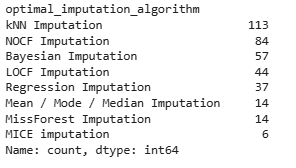

#### Variable initialisation - Class weighting

In [ ]:
# Variable initalisation for experiment 1 - Class weighting
prev_experiment_stats_file = os.path.join(machine_learning_folder, original_stats_folder, model_stats_file)
prev_experiment_label = f"Current Model - No class weights"

# Set the learning rates to be tested
classess_weighted_labels = ["Classes weighted"] + [prev_experiment_label]

# Set folders for the saving of stats, models and figures
first_experiment1_stats_folder = "first_experiement1_model_stats"
first_experiment1_image_folder = "first_experiement1_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, first_experiment1_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, first_experiment1_stats_folder))
    print(f"Folder '{first_experiment1_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, first_experiment1_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, first_experiment1_image_folder))
    print(f"Folder '{first_experiment1_image_folder}' created.")

#### Running experiment - Class weighting

In [ ]:
# Running the code for experiment 1 - Class weighting


# Enable egear execution
tf.compat.v1.enable_eager_execution()

# Get the inital data needed for training
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

# Use current iteration save spaces to configure callbacks
current_iteration_callbacks = configure_callbacks(
    model_stats_save_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, f"iteration1_model_stats.csv"),
    model_image_save_file = os.path.join(machine_learning_folder, first_experiment1_image_folder, f"iteration1_model_image.keras")
)

# Initalise model and callbacks with default parameters
optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
model = configure_model(
    learning_rate = learning_rate,
    classes = num_classes,
    loss_function = loss_function,
    optimizer = optimizer,
    initializer = initializer,
    dropout_rate = dropout_rate,
    extra_layer_switches = extra_layer_switches,
    has_augment = has_augment,
    augment_prob = augment_prob
)

if is_datasets:
  history = model.fit(
      train_data,
      validation_data = validation_data,
      batch_size = batch_size,
      epochs = epochs,
      callbacks = current_iteration_callbacks,
      verbose=1,
      class_weight=class_weight_dict
  )

else:
  history = model.fit(
      train_data[0],
      train_data[1],
      validation_data = (validation_data[0], validation_data[1]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = current_iteration_callbacks,
      verbose=1,
      class_weight=class_weight_dict
  )

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2662 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2807 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2774 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2941 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2801 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 6/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2854 - loss: na

#### Analyse experiment - Class weighting

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539


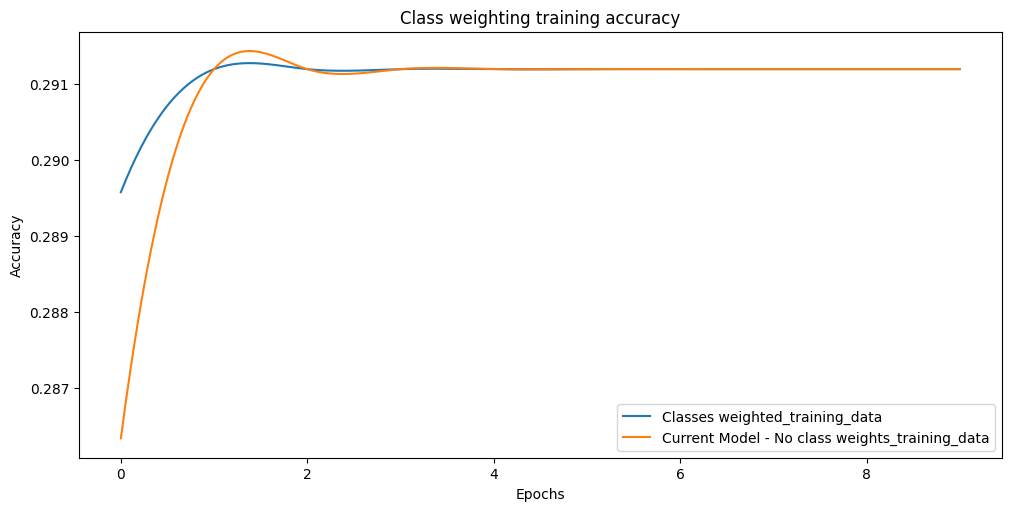

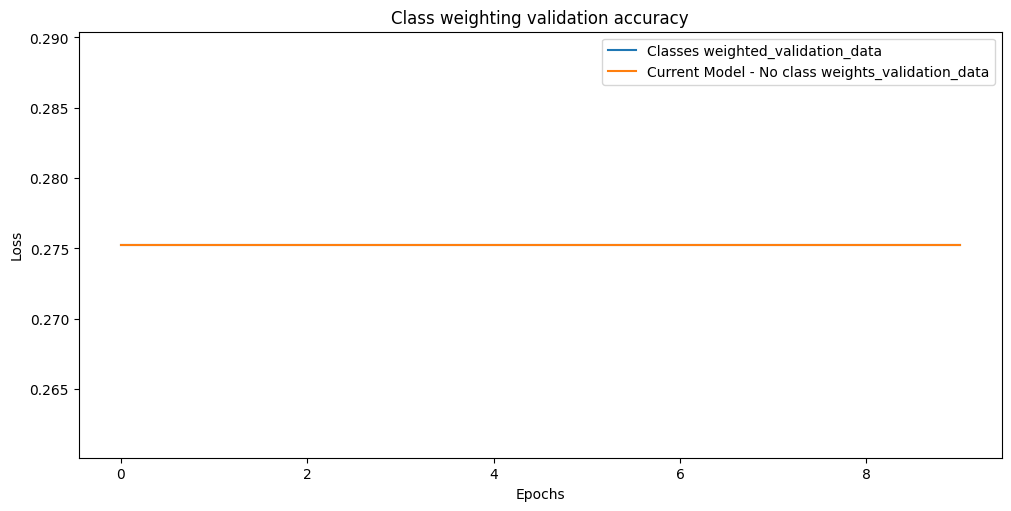

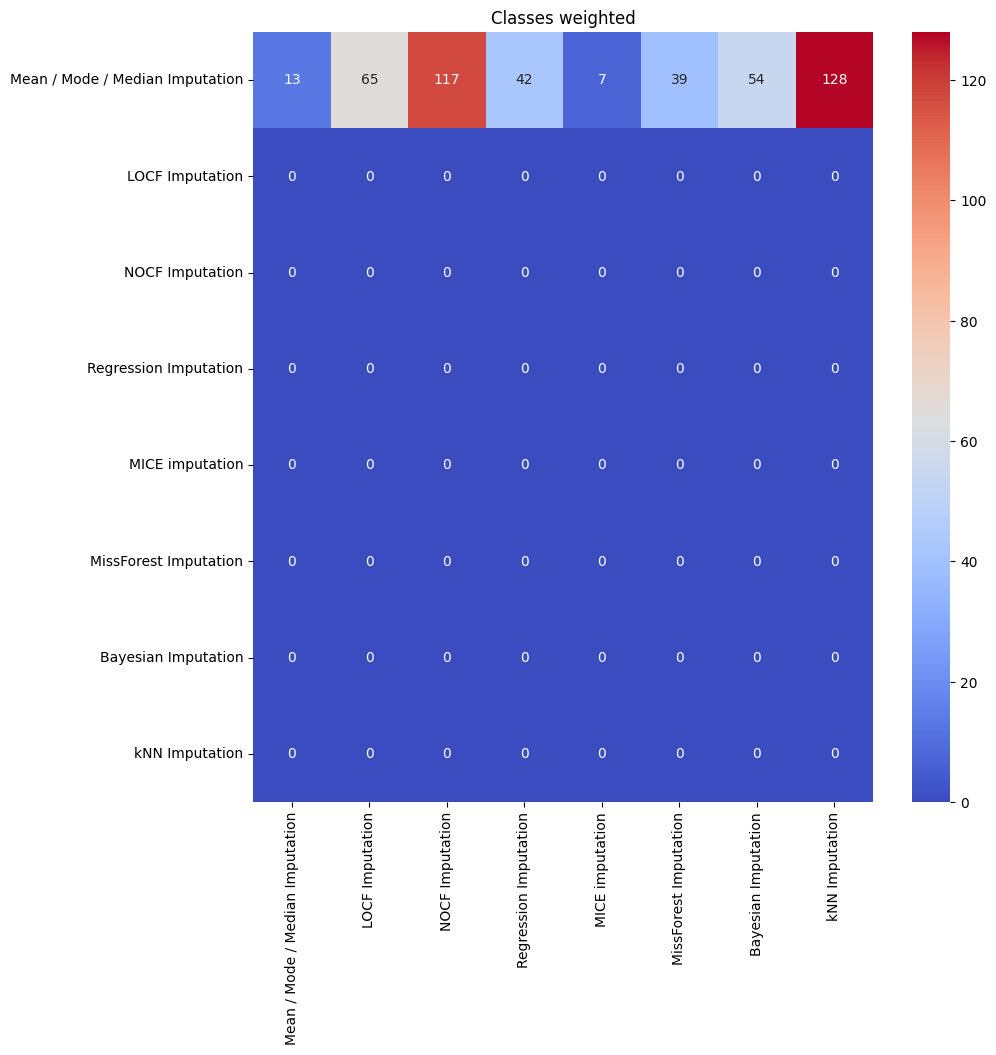

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 1 - Class weighting

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, first_experiment1_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, classess_weighted_labels, "Class weighting", os.path.join(machine_learning_folder, first_experiment1_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, classess_weighted_labels, "Class weighting training accuracy", os.path.join(machine_learning_folder, first_experiment1_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, classess_weighted_labels, "Class weighting validation accuracy", os.path.join(machine_learning_folder, first_experiment1_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, first_experiment1_image_folder), validation_data, class_names, classess_weighted_labels, os.path.join(machine_learning_folder, first_experiment1_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, first_experiment1_image_folder), [(validation_data[0], validation_data[1])], class_names, classess_weighted_labels, os.path.join(machine_learning_folder, first_experiment1_stats_folder))


# End of code block

#### Results - Batch size tunning

This experiments has produced the same training and validation accuracy and the confusion matrix that seems to suggest that the model still converges to only select the Mean / Mode / Median imputation algorithm

# **Second Experiments**

In this section we experiment with filtering the data based on the least frequent class to reduce the effect of the imbalance in the data when training in an attempt to increase the accuracy of the model

## Second Loading the datasets

In this section create a new function to load the statistics files from each missingness mechansims folder except with the functionality of filtering the datasets to contain the same number of instances of each optimal imputation algorithm, this balance the data for the upcoming experiments.

In [ ]:
def second_load_dataset(download_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size):


  # Load stats file
  if not os.path.exists(os.path.join(download_path, imputation_stats_folder, imputation_stats_file)):


    return None


  # Load dataset into DataFrame
  with open(os.path.join(download_path, imputation_stats_folder, imputation_stats_file), 'r') as json_data:
    imputation_stats_JSON = json.loads(json_data.read())
    imputation_stats = pd.json_normalize(imputation_stats_JSON)


  # Balance the dataset data - filter by the number of occuerances of the least common algorithm
  min_imputation_algorithm_occurances = np.min(list(imputation_stats["optimal_imputation_algorithm"].value_counts()))
  imputation_stats = imputation_stats.groupby("optimal_imputation_algorithm").head(min_imputation_algorithm_occurances)

  # Seperate into data and labels
  imputation_stats_algorithms_labels = np.array(imputation_stats["optimal_imputation_algorithm"])
  imputation_stats.drop("optimal_imputation_algorithm", axis=1, inplace=True)
  imputation_stats_metafeatures = np.array([row.tolist() for _, row in imputation_stats.iterrows()])

  # One-hot encode labels
  imputation_stats_algorithms_string_labels = tf.constant(imputation_stats_algorithms_labels)
  imputation_stats_algorithms_labels_enocded = lookup_imputation_table.lookup(imputation_stats_algorithms_string_labels)
  imputation_stats_algorithms_labels_enocded = np.array(to_categorical(imputation_stats_algorithms_labels_enocded, num_classes))

  # Split into training and validation datasets
  X_train, X_test, y_train, y_test = train_test_split(imputation_stats_metafeatures, imputation_stats_algorithms_labels_enocded, test_size=0.2, random_state=42)

  # shuffle the data
  perm_train = np.random.permutation(len(X_train))
  X_train = X_train[perm_train]
  y_train = y_train[perm_train]

  perm_test = np.random.permutation(len(X_test))
  X_test = X_test[perm_test]
  y_test = y_test[perm_test]

  # Clean the data
  X_train = np.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=1.0)
  X_test = np.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=1.0)
  y_train = np.nan_to_num(y_train, nan=0.0, posinf=1.0, neginf=1.0)
  y_test = np.nan_to_num(y_test, nan=0.0, posinf=1.0, neginf=1.0)

  training_datasets = (X_train, y_train) if not in_datasets else tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
  validation_datasets = (X_test, y_test) if not in_datasets else tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1000).batch(batch_size)


  return training_datasets, validation_datasets




def second_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size):

  # Load datasets for each missingness mechansim
  mcar_datasets_train, mcar_datasets_test = second_load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)
  mar_datasets_train, mar_datasets_test = second_load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)
  mnar_datasets_train, mnar_datasets_test = second_load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)

  datasets_train = None
  datasets_test = None
  display_train_labels = []


  if not in_datasets:
    datasets_train = list(itertools.chain.from_iterable([mcar_datasets_train, mar_datasets_train, mnar_datasets_train]))
    datasets_test = list(itertools.chain.from_iterable([mcar_datasets_test, mar_datasets_test, mnar_datasets_test]))

    display_train_labels = datasets_train[1]

  else:
    datasets_train = mcar_datasets_train.concatenate(mar_datasets_train).concatenate(mnar_datasets_train)
    datasets_test = mcar_datasets_test.concatenate(mar_datasets_test).concatenate(mnar_datasets_test)


    for batch in datasets_train:
      labels = batch[1]


      for label in labels:
        display_train_labels.append(label)


  # Display the new class distribution
  unencoded_labels = tf.argmax(display_train_labels, axis=1)
  unencoded_labels = tf.cast(unencoded_labels, dtype=tf.int32)
  imputation_algorithms = np.array([lookup_imputation_table_inverse.lookup(label_index).numpy().decode('utf-8') for label_index in unencoded_labels])

  values, counts = np.unique(imputation_algorithms, return_counts=True)


  for val, count in zip(values, counts):
      print(f"Value: {val}, Count: {count}")


  return datasets_train, datasets_test

#### Testing

In [ ]:
# Load datasets for a missingness mechansim
print("MCAR data:")
mcar_datasets_train, mcar_datasets_test = second_load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

print("\nMAR data:")
mcar_datasets_train, mcar_datasets_test = second_load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

print("\nMNAR data:")
mcar_datasets_train, mcar_datasets_test = second_load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

datasets_train, datasets_test = second_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, True, 40)

MCAR data:

MAR data:

MNAR data:
Value: Bayesian Imputation, Count: 33
Value: LOCF Imputation, Count: 31
Value: MICE imputation, Count: 30
Value: Mean / Mode / Median Imputation, Count: 29
Value: MissForest Imputation, Count: 28
Value: NOCF Imputation, Count: 31
Value: Regression Imputation, Count: 31
Value: kNN Imputation, Count: 28


## Second experiments parameter initialisation

Here we keep most of the same parameters but adjust the layers and the batch size to account for the smaller amount of data the model will be receiving

In [ ]:
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.90
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)
is_datasets = True

## Second Experiment 2 - Filtering classes

In this experiment we test the new model with a new balanced dataset (more data was collected and subsequently filtered so that each imputation algorithm occured in the labels the same amount X - the number of occurances of the least common algorithm) The hope of this experiment is that it will improve performance and the models ability to differential between different imputation algorithms unlike the class weighting technique in the previous experiments. Each of tables below show the number of occurances of each labels for each misisngness mechansim, from here it can be seen that in the total dataset there should be 38 datasets for each 8 algorithms totalling 308 datasets.

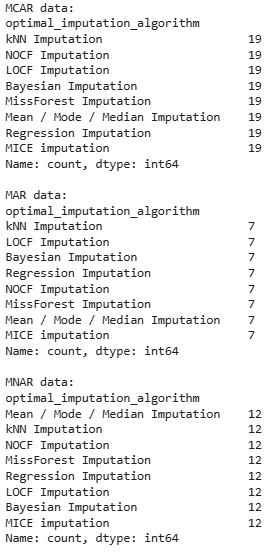

#### Variable initialisation - Filtering classes

In [ ]:
# Variable initalisation for experiment 2 - Filtering classes

# Set the learning rates to be tested
new_model_labels = ["Filtering classes"] + ["First experiment - Class weighting"]
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")

# Set folders for the saving of stats, models and figures
second_experiment2_stats_folder = "second_experiement2_model_stats"
second_experiment2_image_folder = "second_experiement2_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, second_experiment2_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, second_experiment2_stats_folder))
    print(f"Folder '{second_experiment2_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, second_experiment2_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, second_experiment2_image_folder))
    print(f"Folder '{second_experiment2_image_folder}' created.")

#### Running experiment - Filtering classes

In [ ]:
# Running the code for experiment 2 - Filtering classes


# Enable egear execution
tf.compat.v1.enable_eager_execution()

# Get the inital data needed for training
train_data, validation_data = second_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

# Use current iteration save spaces to configure callbacks
current_iteration_callbacks = configure_callbacks(
    model_stats_save_file = os.path.join(machine_learning_folder, second_experiment2_stats_folder, f"iteration1_model_stats.csv"),
    model_image_save_file = os.path.join(machine_learning_folder, second_experiment2_image_folder, f"iteration1_model_image.keras")
)

# Initalise model and callbacks with default parameters
optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
model = configure_model(
    learning_rate = learning_rate,
    classes = num_classes,
    loss_function = loss_function,
    optimizer = optimizer,
    initializer = initializer,
    dropout_rate = dropout_rate,
    extra_layer_switches = extra_layer_switches,
    has_augment = has_augment,
    augment_prob = augment_prob
)

if is_datasets:
  history = model.fit(
      train_data,
      validation_data = validation_data,
      batch_size = batch_size,
      epochs = epochs,
      callbacks = current_iteration_callbacks,
      verbose=1
  )

else:
  history = model.fit(
      train_data[0],
      train_data[1],
      validation_data = (validation_data[0], validation_data[1]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = current_iteration_callbacks,
      verbose=1
  )

Value: Bayesian Imputation, Count: 33
Value: LOCF Imputation, Count: 31
Value: MICE imputation, Count: 30
Value: Mean / Mode / Median Imputation, Count: 29
Value: MissForest Imputation, Count: 28
Value: NOCF Imputation, Count: 31
Value: Regression Imputation, Count: 31
Value: kNN Imputation, Count: 28
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1271 - loss: nan - val_accuracy: 0.1587 - val_loss: nan
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1127 - loss: nan - val_accuracy: 0.1587 - val_loss: nan
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1243 - loss: nan - val_accuracy: 0.1587 - val_loss: nan
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1342 - loss: nan - val_accuracy: 0.1587 - val_loss: nan
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1301 - loss: nan - val_accuracy: 0.1587 - val_loss: nan
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1429 - loss: nan - val_accuracy:

#### Analyse experiment - Filtering classes

Value: Bayesian Imputation, Count: 33
Value: LOCF Imputation, Count: 31
Value: MICE imputation, Count: 30
Value: Mean / Mode / Median Imputation, Count: 29
Value: MissForest Imputation, Count: 28
Value: NOCF Imputation, Count: 31
Value: Regression Imputation, Count: 31
Value: kNN Imputation, Count: 28


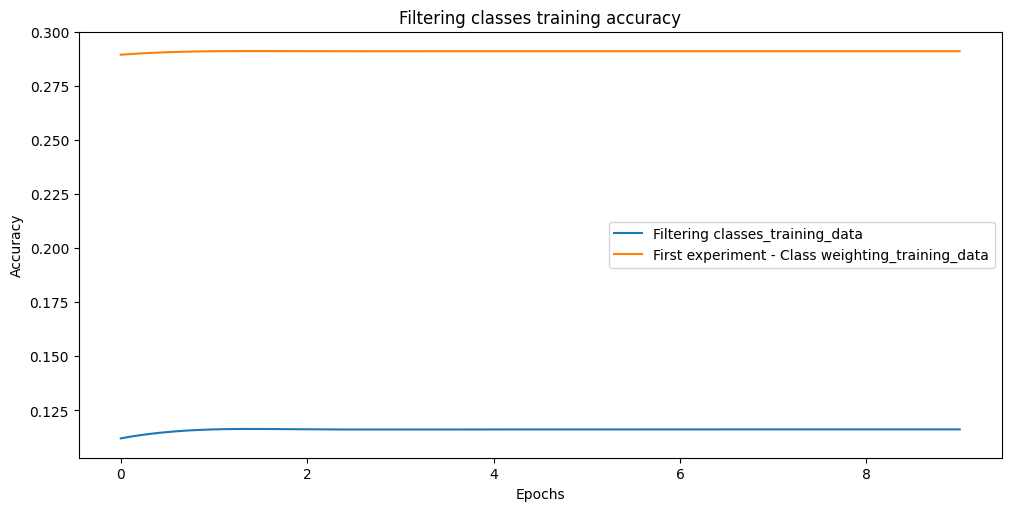

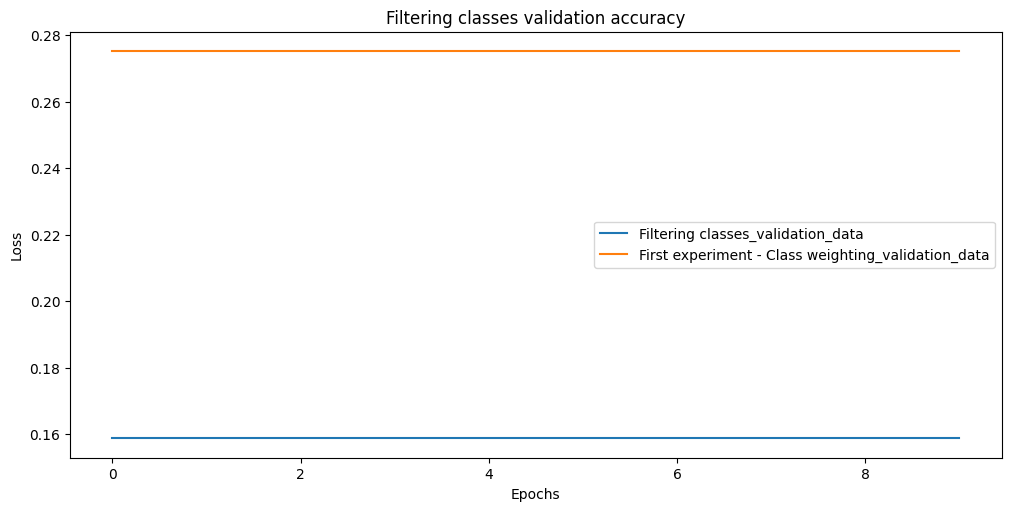

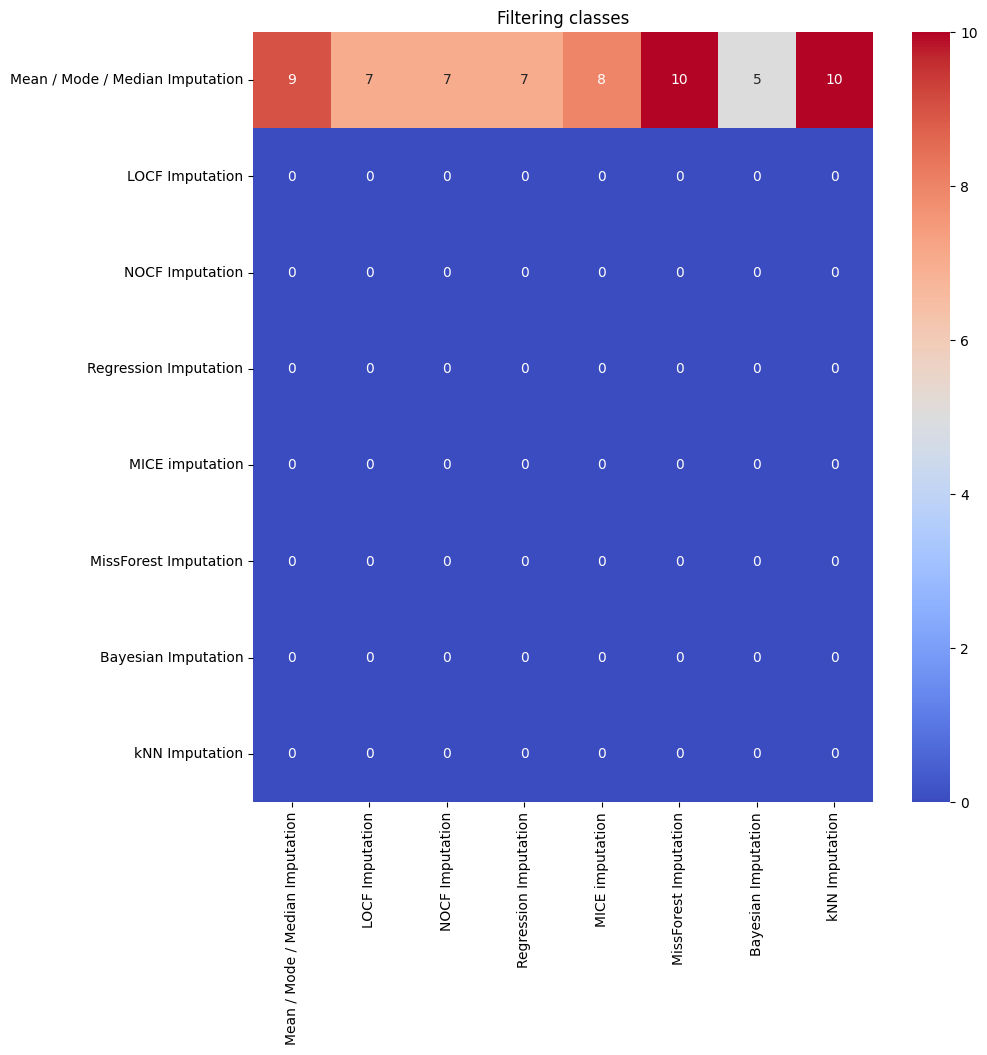

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 2 - Filtering classes

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data = second_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, second_experiment2_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, new_model_labels, "Filtering classes", os.path.join(machine_learning_folder, second_experiment2_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, new_model_labels, "Filtering classes training accuracy", os.path.join(machine_learning_folder, second_experiment2_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, new_model_labels, "Filtering classes validation accuracy", os.path.join(machine_learning_folder, second_experiment2_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, second_experiment2_image_folder), validation_data, class_names, new_model_labels, os.path.join(machine_learning_folder, second_experiment2_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, second_experiment2_image_folder), [(validation_data[0], validation_data[1])], class_names, new_model_labels, os.path.join(machine_learning_folder, second_experiment1_stats_folder))


# End of code block

#### Results - Filtering classes

This second experiment using the data filltered by classess to balances the classess proves to produce a worse model that the original class weighting model as it runs into a validation wall at a much lower percentage of accuracy. This is now most liklely due to the model not having enough data to properly train the complexity of the archiecture.

# **Third Experiments**

In this section we experiment with oversampling techniques like SMOTE to counteract the imbalance issue whilst not sacrificing the amount of data clearly needed to train the new model architecture

## Third Loading the datasets

In this section create a new function to load the statistics files from each missingness mechansims folder except with the functionality of applying the SMOTE oversampling technique to generate more data to train the model and class balance the datasets

In [ ]:
def third_load_dataset(download_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size):


  # Load stats file
  if not os.path.exists(os.path.join(download_path, imputation_stats_folder, imputation_stats_file)):


    return None


  # Load dataset into DataFrame
  with open(os.path.join(download_path, imputation_stats_folder, imputation_stats_file), 'r') as json_data:
    imputation_stats_JSON = json.loads(json_data.read())
    imputation_stats = pd.json_normalize(imputation_stats_JSON)


  # Seperate into data and labels
  imputation_stats_algorithms_labels = np.array(imputation_stats["optimal_imputation_algorithm"])
  imputation_stats.drop("optimal_imputation_algorithm", axis=1, inplace=True)
  imputation_stats_metafeatures = np.array([row.tolist() for _, row in imputation_stats.iterrows()])

  # One-hot encode labels
  imputation_stats_algorithms_string_labels = tf.constant(imputation_stats_algorithms_labels)
  imputation_stats_algorithms_labels_enocded = lookup_imputation_table.lookup(imputation_stats_algorithms_string_labels)
  imputation_stats_algorithms_labels_enocded = np.array(to_categorical(imputation_stats_algorithms_labels_enocded, num_classes))

  # Split into training and validation datasets
  X_train, X_test, y_train, y_test = train_test_split(imputation_stats_metafeatures, imputation_stats_algorithms_labels_enocded, test_size=0.2, random_state=42)

  # shuffle the data
  perm_train = np.random.permutation(len(X_train))
  X_train = X_train[perm_train]
  y_train = y_train[perm_train]

  perm_test = np.random.permutation(len(X_test))
  X_test = X_test[perm_test]
  y_test = y_test[perm_test]

  # Impute NaN values with 0 before applying SMOTE / Clean the data
  X_train = np.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=1.0)
  X_test = np.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=1.0)
  y_train = np.nan_to_num(y_train, nan=0.0, posinf=1.0, neginf=1.0)
  y_test = np.nan_to_num(y_test, nan=0.0, posinf=1.0, neginf=1.0)

  training_datasets = (X_train, y_train)
  validation_datasets = (X_test, y_test)


  return training_datasets, validation_datasets




def third_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size):

  # Load datasets for each missingness mechansim
  mcar_datasets_train, mcar_datasets_test = third_load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)
  mar_datasets_train, mar_datasets_test = third_load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)
  mnar_datasets_train, mnar_datasets_test = third_load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, in_datasets, batch_size)

  datasets_train = None
  datasets_test = None


  datasets_train = list(itertools.chain.from_iterable([mcar_datasets_train, mar_datasets_train, mnar_datasets_train]))
  datasets_test = list(itertools.chain.from_iterable([mcar_datasets_test, mar_datasets_test, mnar_datasets_test]))

  smote = SMOTE(random_state=42, k_neighbors=3)
  datasets_train[0], datasets_train[1] = smote.fit_resample(datasets_train[0], datasets_train[1])

  unencoded_labels = tf.argmax(datasets_train[1], axis=1)
  unencoded_labels = tf.cast(unencoded_labels, dtype=tf.int32)
  imputation_algorithms = np.array([lookup_imputation_table_inverse.lookup(label_index).numpy().decode('utf-8') for label_index in unencoded_labels])

  values, counts = np.unique(imputation_algorithms, return_counts=True)


  for val, count in zip(values, counts):
      print(f"Value: {val}, Count: {count}")


  if in_datasets:
    datasets_train = tf.data.Dataset.from_tensor_slices((datasets_train[0], datasets_train[1])).shuffle(1000).batch(batch_size)
    datasets_test = tf.data.Dataset.from_tensor_slices((datasets_test[0], datasets_test[1])).shuffle(1000).batch(batch_size)


  return datasets_train, datasets_test

#### Testing

In [ ]:
# Load datasets for a missingness mechansim
print("MCAR data:")
mcar_datasets_train, mcar_datasets_test = third_load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

print("\nMAR data:")
mcar_datasets_train, mcar_datasets_test = third_load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

print("\nMNAR data:")
mcar_datasets_train, mcar_datasets_test = third_load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

datasets_train, datasets_test = third_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, False, 40)

MCAR data:

MAR data:

MNAR data:
Value: Bayesian Imputation, Count: 187
Value: LOCF Imputation, Count: 187
Value: MICE imputation, Count: 187
Value: Mean / Mode / Median Imputation, Count: 187
Value: MissForest Imputation, Count: 187
Value: NOCF Imputation, Count: 187
Value: Regression Imputation, Count: 187
Value: kNN Imputation, Count: 187


## Third experiments parameter initialisation

Here we keep most of the same parameters but increase starting batch size to accomodate the increase in the amount of data from both sections of experimentation

In [ ]:
learning_rate = 0.007
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.90
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 16
epochs = 10
num_input = 40
num_classes = len(class_names)
is_datasets = True

## Third Experiment 1 - Oversampling Data

In this experiment we test the new model with a oversampled balanced dataset (the SMOTE technique was implemented in the new data loading process which generates more data for undersampled / uncommon classess in the datasets using previous datasets with the same labelling) The hope of this experiment is that it will improve performance unlike the class weighting and filterting techniques in the previous experiments. The table below shows that each datasets has been balanced like in experiment 2 but has much more data (specifically 209 datasets for each 8 classess meaning 1692 datasets to train the model with)


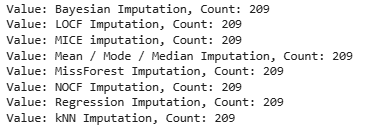

#### Variable initialisation - Oversampling Data

In [ ]:
# Variable initalisation for experiment 1 - Oversampling Data

# Set the learning rates to be tested
new_model_labels = ["Oversampling Data"] + ["First experiment - Class weighting"]
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")

# Set folders for the saving of stats, models and figures
third_experiement1_stats_folder = "third_experiement1_model_stats"
third_experiement1_image_folder = "third_experiement1_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, third_experiement1_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, third_experiement1_stats_folder))
    print(f"Folder '{third_experiement1_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, third_experiement1_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, third_experiement1_image_folder))
    print(f"Folder '{third_experiement1_image_folder}' created.")

#### Running experiment - Oversampling Data

In [ ]:
# Running the code for experiment 1 - Oversampling Data


# Enable egear execution
tf.compat.v1.enable_eager_execution()

# Get the inital data needed for training
train_data, validation_data = third_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

# Use current iteration save spaces to configure callbacks
current_iteration_callbacks = configure_callbacks(
    model_stats_save_file = os.path.join(machine_learning_folder, third_experiement1_stats_folder, f"iteration1_model_stats.csv"),
    model_image_save_file = os.path.join(machine_learning_folder, third_experiement1_image_folder, f"iteration1_model_image.keras")
)

# Initalise model and callbacks with default parameters
optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
model = configure_model(
    learning_rate = learning_rate,
    classes = num_classes,
    loss_function = loss_function,
    optimizer = optimizer,
    initializer = initializer,
    dropout_rate = dropout_rate,
    extra_layer_switches = extra_layer_switches,
    has_augment = has_augment,
    augment_prob = augment_prob
)

if is_datasets:
  history = model.fit(
      train_data,
      validation_data = validation_data,
      batch_size = batch_size,
      epochs = epochs,
      callbacks = current_iteration_callbacks,
      verbose=1
  )

else:
  history = model.fit(
      train_data[0],
      train_data[1],
      validation_data = (validation_data[0], validation_data[1]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = current_iteration_callbacks,
      verbose=1
  )

Value: Bayesian Imputation, Count: 187
Value: LOCF Imputation, Count: 187
Value: MICE imputation, Count: 187
Value: Mean / Mode / Median Imputation, Count: 187
Value: MissForest Imputation, Count: 187
Value: NOCF Imputation, Count: 187
Value: Regression Imputation, Count: 187
Value: kNN Imputation, Count: 187
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1429 - loss: nan - val_accuracy: 0.2706 - val_loss: nan
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1331 - loss: nan - val_accuracy: 0.2706 - val_loss: nan
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1440 - loss: nan - val_accuracy: 0.2706 - val_loss: nan
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1426 - loss: nan - val_accuracy: 0.2706 - val_loss: nan
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1412 - loss: nan - val_accuracy: 0.2706 - val_loss: nan
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1377 - loss: nan - val_a

#### Analyse experiment - Oversampling Data

Value: Bayesian Imputation, Count: 187
Value: LOCF Imputation, Count: 187
Value: MICE imputation, Count: 187
Value: Mean / Mode / Median Imputation, Count: 187
Value: MissForest Imputation, Count: 187
Value: NOCF Imputation, Count: 187
Value: Regression Imputation, Count: 187
Value: kNN Imputation, Count: 187


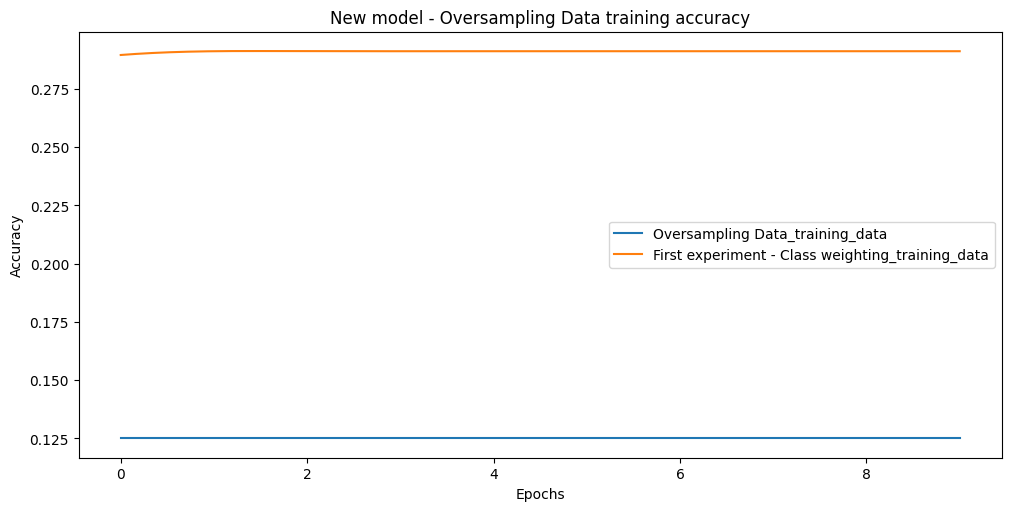

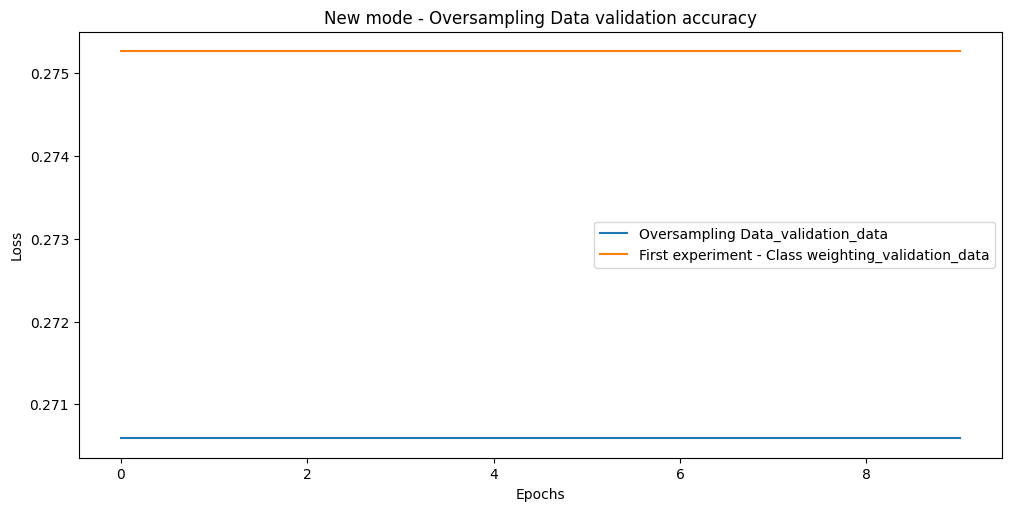

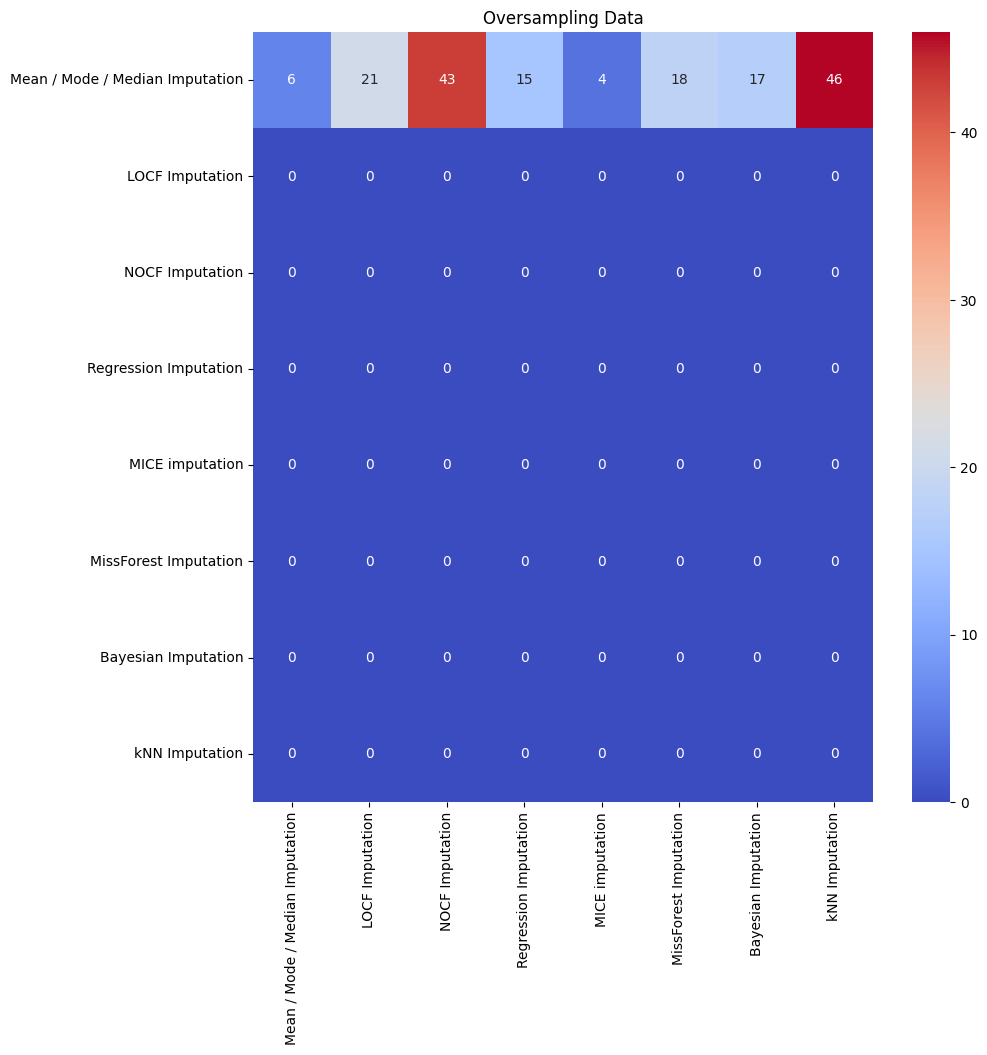

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 1 - Oversampling Data

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data = third_load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, third_experiement1_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, new_model_labels, "New model - Oversampling Data", os.path.join(machine_learning_folder, third_experiement1_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, new_model_labels, "New model - Oversampling Data training accuracy", os.path.join(machine_learning_folder, third_experiement1_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, new_model_labels, "New mode - Oversampling Data validation accuracy", os.path.join(machine_learning_folder, third_experiement1_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, third_experiement1_image_folder), validation_data, class_names, new_model_labels, os.path.join(machine_learning_folder, third_experiement1_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, third_experiement1_image_folder), [(validation_data[0], validation_data[1])], class_names, new_model_labels, os.path.join(machine_learning_folder, second_experiment1_stats_folder))


# End of code block

#### Results - New model

This third experiment with the data oversmapled by the SMOTE algorithm proves to only be slighly worse that the class weighting technique of experiment 1. This is likely due to the SMOTE algorithm having to generate a very large amount of data for the classess that have a very limited amount of data for which to base these generated instances on (such as MissForest which has only around 30 entries meaning SMOTE generated around 150 original) Due to the massive class imbalanced between the highest and lowest classess, a large amount of the training data would be artifical

# **Experiments**

In this section we run experiments on the model we have created in an attempt to optimise its performance (accuracy, precision, etc) These experiments will require the configuration of a new model (with adjusted parameters based on the experiments) which will be subsequently be trained and tested. The results of the training and testing will be used to determine the optimal configration of the model (optimal parameters) The most current version of the model (based on all previous experiments) will be configured at the end of the experiment and recorded

Moving foward after the experiments to determine which data balancing technique is best used to class balanced the training data we will be implementing the class weightinh technique as this gave the best training and validation accuracy scores in all instances and uses completely authentic data.

## Parameter initialisation

Here we initialise the parameters in what would be considered a default state (parameters that arent too big or too small as to not push the model to any kind of extremes)

In [ ]:
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)
is_datasets = True

## Experiment 2 - Adding layers to the model

In this experiment we adjust the number of layers in the model in an attempt to optimise the model

In the previous experiment the model still was only predicting a dataset to belong to one of two classess. Hopfully adding more layers will the model to differentiate between the datasets more to put them in different classes.

#### Variable initialisation - Adding layers to the model

In [ ]:
# Variable initalisation for experiment 2 - Adding layers to the model
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")
prev_experiment_label = f"Current Model - Number of extra layers: {sum(extra_layer_switches)}"

# Set the learning rates to be tested
extra_layer_switches_list = [
    [True, False, False, False, False],
    [True, True, False, False, False],
    [True, True, True, False, False],
    [True, True, True, True, False],
    [True, True, True, True, True]
]
extra_layer_switches_labels = [f"Number of extra layers: {sum(extra_layer_switches)}" for extra_layer_switches in extra_layer_switches_list] + [prev_experiment_label]

# Set folders for the saving of stats, models and figures
experiment2_stats_folder = "experiement2_model_stats"
experiment2_image_folder = "experiement2_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, experiment2_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment2_stats_folder))
    print(f"Folder '{experiment2_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, experiment2_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment2_image_folder))
    print(f"Folder '{experiment2_image_folder}' created.")

#### Running experiment - Adding layers to the model

In [ ]:
# Running the code for experiment 2 - Adding layers to the model


# Run experiment, looping through the layer switches:
for index in range(0, len(extra_layer_switches_list)):
  print("\n\n----------------------------------------------------------------------------", f"Running iteration {str(index+1)}: Number of extra layers: {str(sum(extra_layer_switches_list[index]))}")

  # Enable egear execution
  tf.compat.v1.enable_eager_execution()

  # Get the inital data needed for training
  train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

  extra_layer_switches = extra_layer_switches_list[index] # Get the extra layer switches

  # Use current iteration save spaces to configure callbacks
  current_iteration_callbacks = configure_callbacks(
      model_stats_save_file = os.path.join(machine_learning_folder, experiment2_stats_folder, f"iteration{str(index+1)}_model_stats.csv"),
      model_image_save_file = os.path.join(machine_learning_folder, experiment2_image_folder, f"iteration{str(index+1)}_model_image.keras")
  )

  # Initalise model and callbacks with default parameters
  optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
  model = configure_model(
      learning_rate = learning_rate,
      classes = num_classes,
      loss_function = loss_function,
      optimizer = optimizer,
      initializer = initializer,
      dropout_rate = dropout_rate,
      extra_layer_switches = extra_layer_switches,
      has_augment = has_augment,
      augment_prob = augment_prob
  )

  if is_datasets:
    history = model.fit(
        train_data,
        validation_data = validation_data,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        # class_weight=class_weight_dict
    )

  else:
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data = (validation_data[0], validation_data[1]),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        # class_weight=class_weight_dict
    )



---------------------------------------------------------------------------- Running iteration 1: Number of extra layers: 1
Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2721 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2715 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2900 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2822 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2621 - loss

#### Analyse experiment - Adding layers to the model

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539


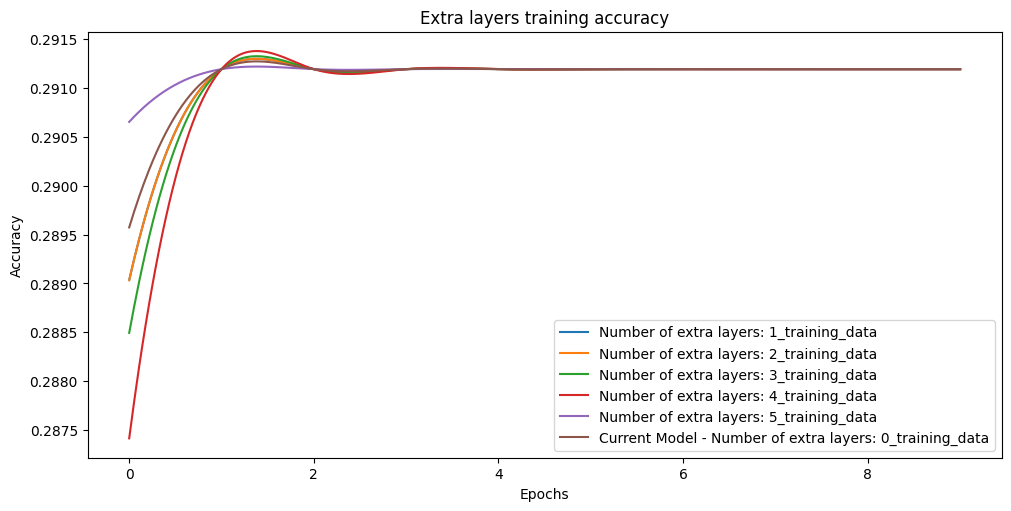

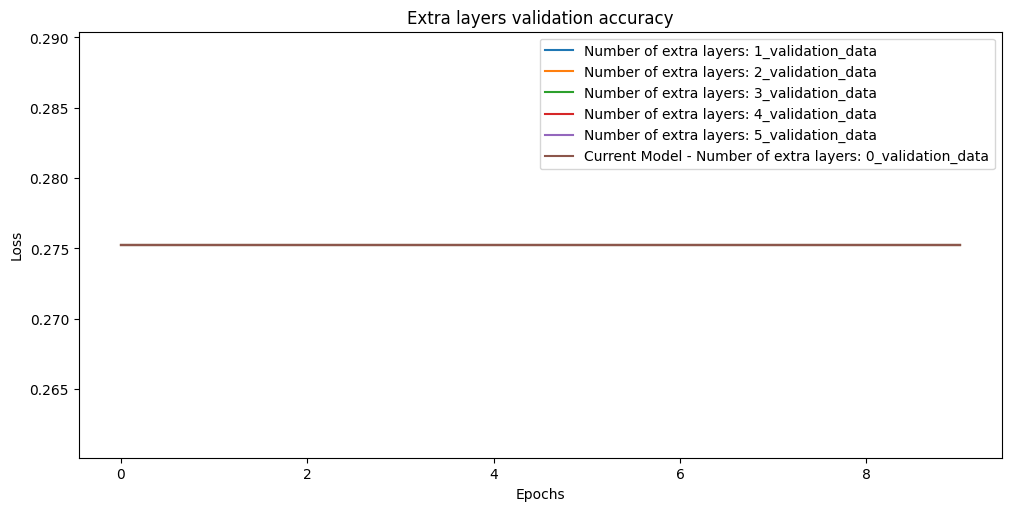

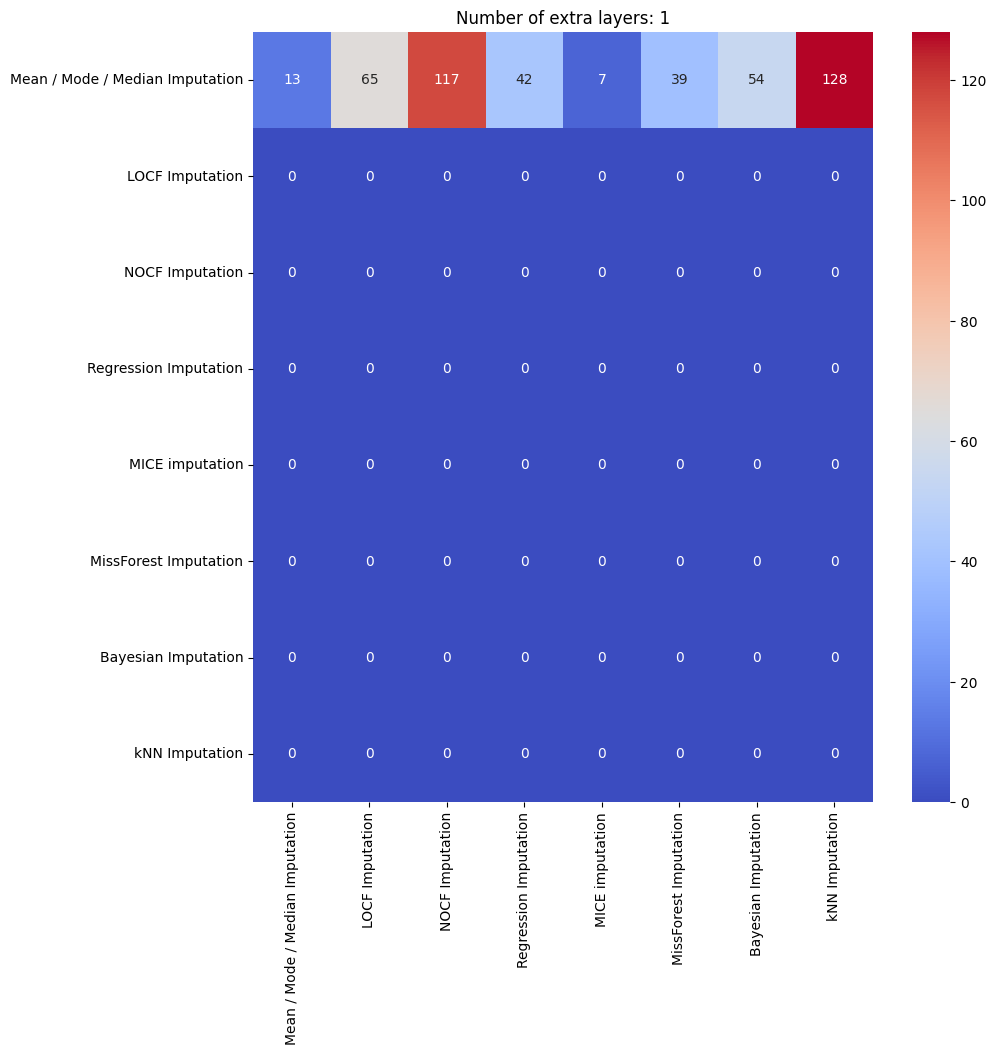

<Figure size 640x480 with 0 Axes>

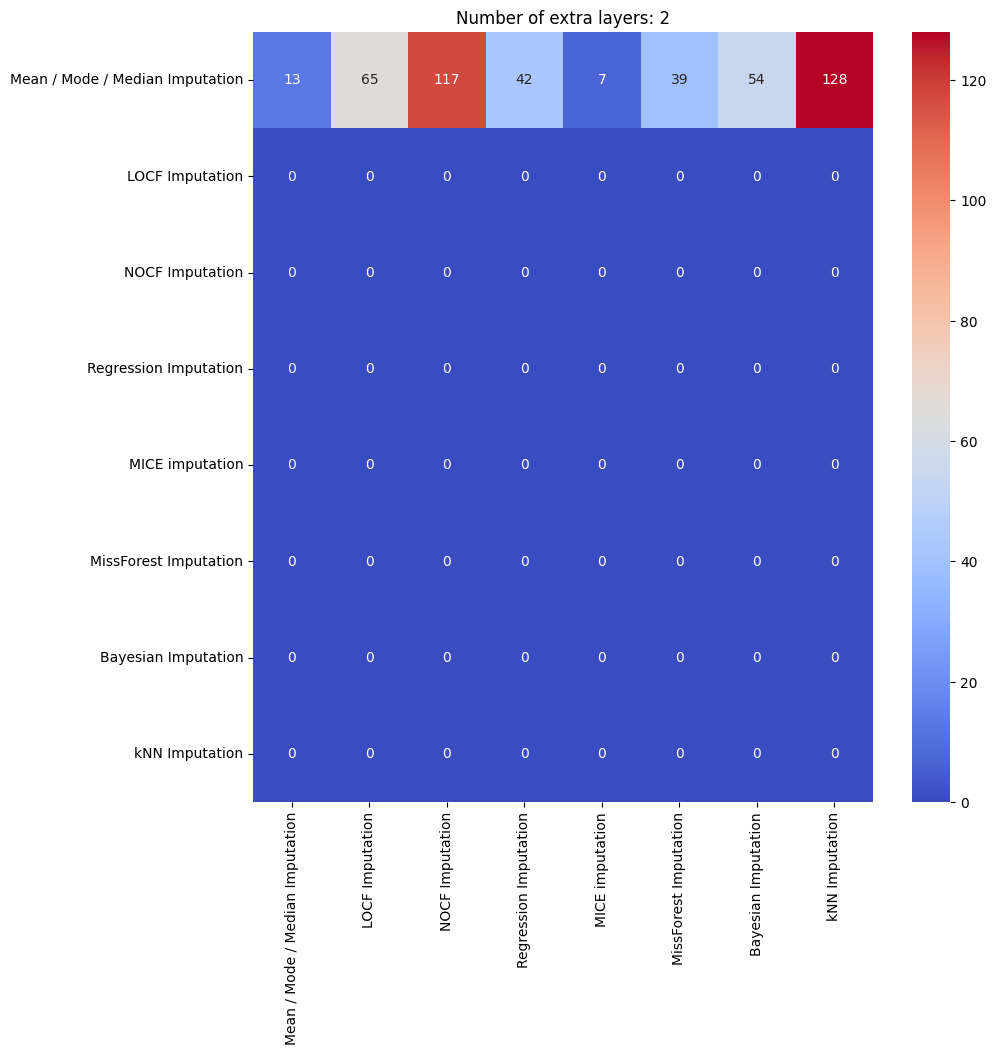

<Figure size 640x480 with 0 Axes>

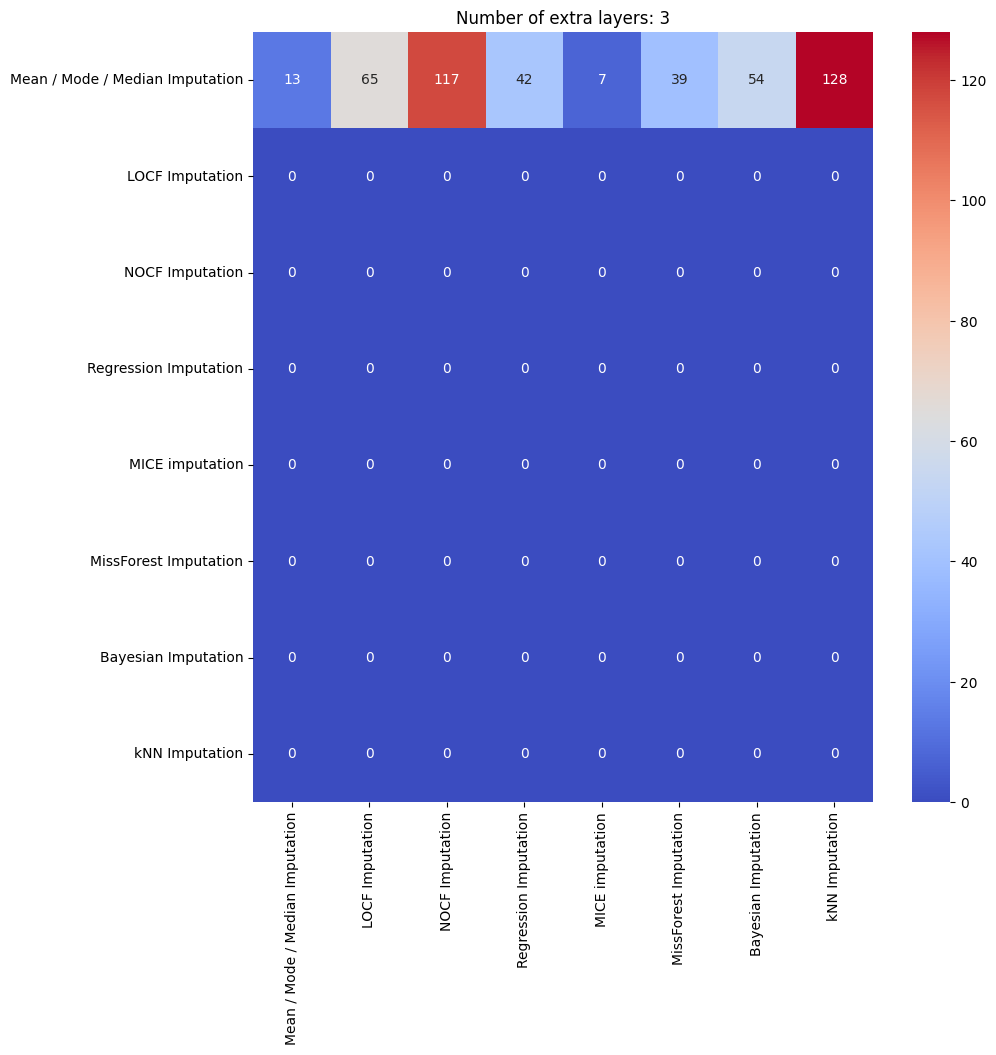

<Figure size 640x480 with 0 Axes>

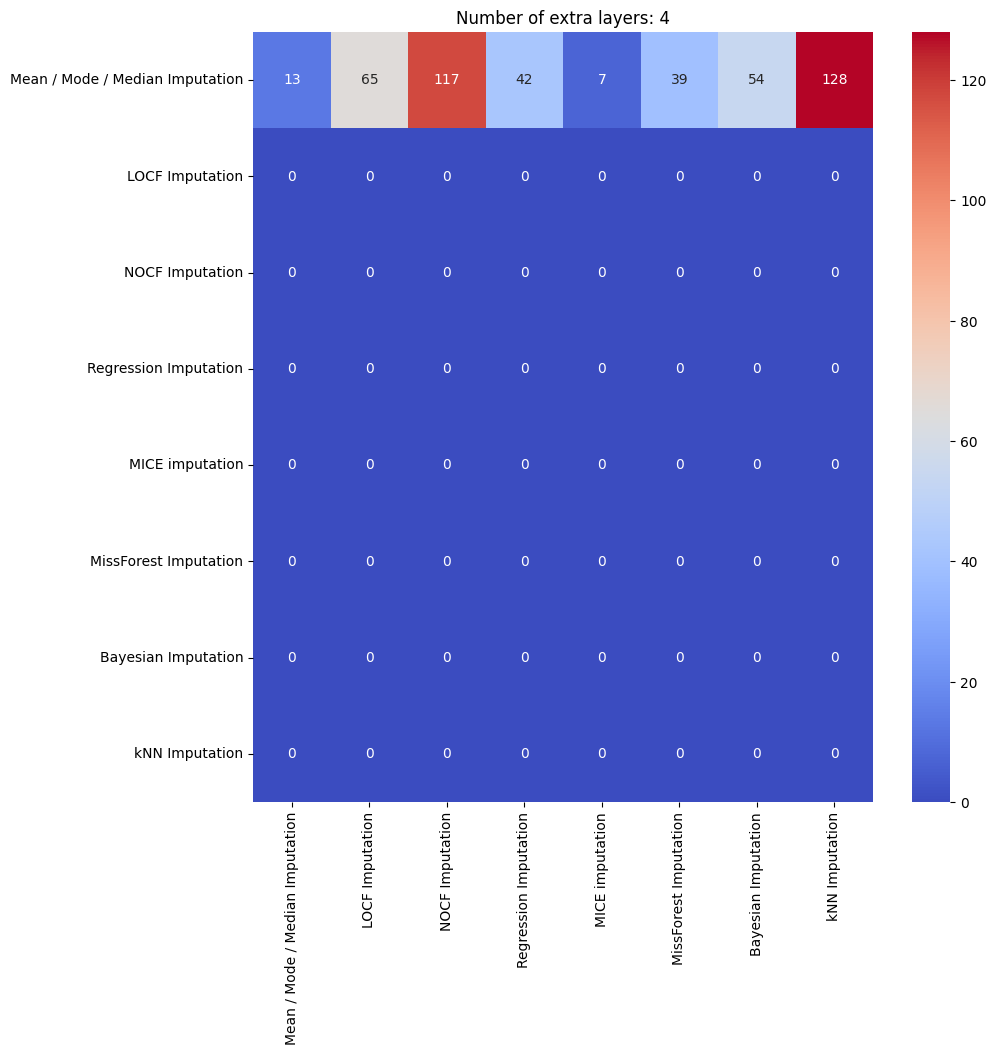

<Figure size 640x480 with 0 Axes>

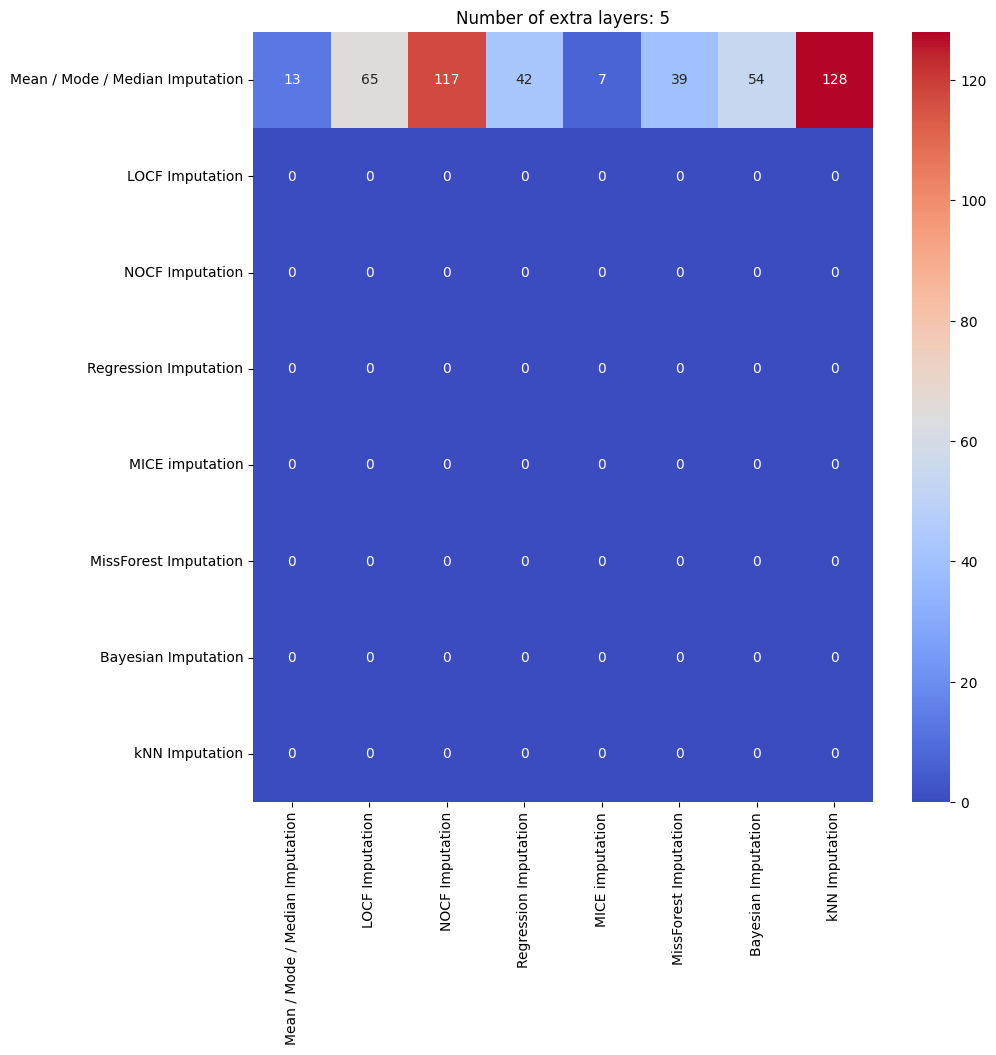

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 2 - Adding layers to the model

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, experiment2_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, extra_layer_switches_labels, "Extra layers", os.path.join(machine_learning_folder, experiment2_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, extra_layer_switches_labels, "Extra layers training accuracy", os.path.join(machine_learning_folder, experiment2_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, extra_layer_switches_labels, "Extra layers validation accuracy", os.path.join(machine_learning_folder, experiment2_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, experiment2_image_folder), validation_data, class_names, extra_layer_switches_labels, os.path.join(machine_learning_folder, experiment2_stats_folder))

else:
  load_keras_confusion(os.path.join(machine_learning_folder, experiment2_image_folder), [(validation_data[0], validation_data[1])], class_names, extra_layer_switches_labels, os.path.join(machine_learning_folder, experiment2_stats_folder))

#### Results - Adding layers to the model

This experiments has shown that adding more layers creates a more stable training and validation slope but after a certain number of layers they all converge to the same validation accuracy and produce the same confusion matrix

#### Adjust model parameters - Adding layers to the model

In [ ]:
# Initialise parameters again

# Set new number of extra layers - from 0 to 0
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)


# Previous model save = "first_experiment1_stats_folder/iteration1_model_stats.csv"

## Experiment 3 - Learning rate tunning

In this experiment we adjust the learning rate in an attempt to optimise the model

#### Variable initialisation - Learning rate tunning

In [ ]:
# Variable initalisation for experiment 3 - Learning rate tunning
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")
prev_experiment_label = f"Current Model - learning rate: {learning_rate}"

# Set the learning rates to be tested
learning_rates = [0.0008, 0.001, 0.003, 0.007, 0.009, 0.012]
learning_rates_labels = [f"Learning rate: {learning_rate}" for learning_rate in learning_rates] + [prev_experiment_label]

# Set folders for the saving of stats, models and figures
experiment3_stats_folder = "experiement3_model_stats"
experiment3_image_folder = "experiement3_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, experiment3_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment3_stats_folder))
    print(f"Folder '{experiment3_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, experiment3_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment3_image_folder))
    print(f"Folder '{experiment3_image_folder}' created.")

#### Running experiment - Learning rate tunning

In [ ]:
# Running the code for experiment 3 - Learning rate tunning


# Run experiment, looping through the learning rates:
for index in range(0, len(learning_rates)):
  print("\n\n----------------------------------------------------------------------------", f"Running iteration {str(index+1)}: learning rate: {str(learning_rates[index])}")

  # Enable egear execution
  tf.compat.v1.enable_eager_execution()

  # Get the inital data needed for training
  train_data, validation_data, _ = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

  learning_rate = learning_rates[index] # Get the learning rate


  # Use current iteration save spaces to configure callbacks
  current_iteration_callbacks = configure_callbacks(
      model_stats_save_file = os.path.join(machine_learning_folder, experiment3_stats_folder, f"iteration{str(index+1)}_model_stats.csv"),
      model_image_save_file = os.path.join(machine_learning_folder, experiment3_image_folder, f"iteration{str(index+1)}_model_image.keras")
  )

  # Initalise model and callbacks with default parameters
  optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
  model = configure_model(
      learning_rate = learning_rate,
      classes = num_classes,
      loss_function = loss_function,
      optimizer = optimizer,
      initializer = initializer,
      dropout_rate = dropout_rate,
      extra_layer_switches = extra_layer_switches,
      has_augment = has_augment,
      augment_prob = augment_prob
  )

  if is_datasets:
    history = model.fit(
        train_data,
        validation_data = validation_data,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )

  else:
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data = (validation_data[0], validation_data[1]),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )



---------------------------------------------------------------------------- Running iteration 1: learning rate: 0.0008
Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2783 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2778 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2751 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2881 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2714 - loss: na

#### Analyse experiment - Learning rate tunning

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539


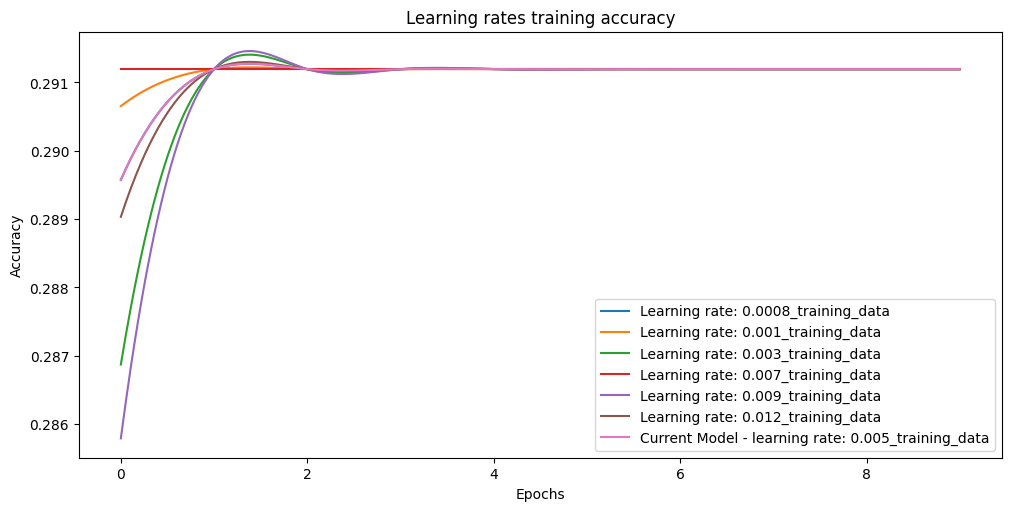

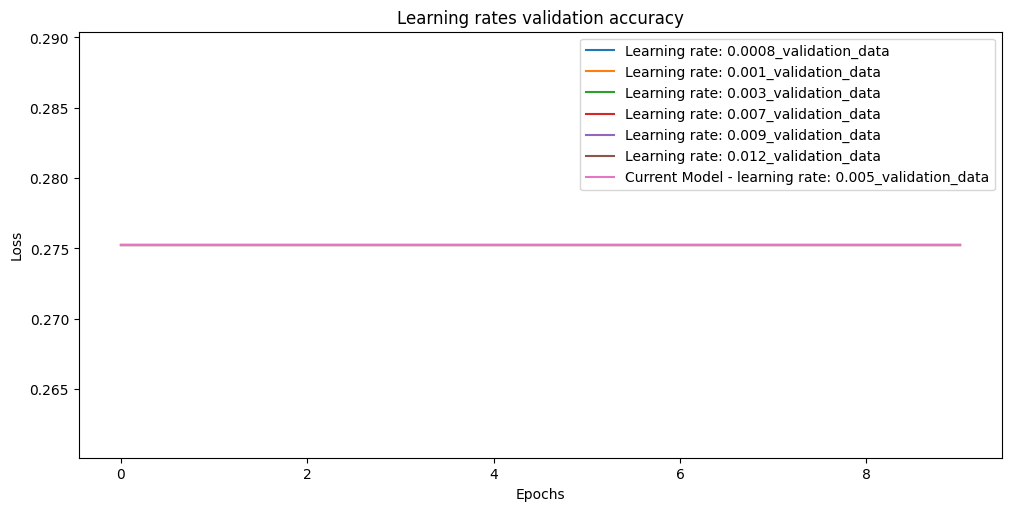

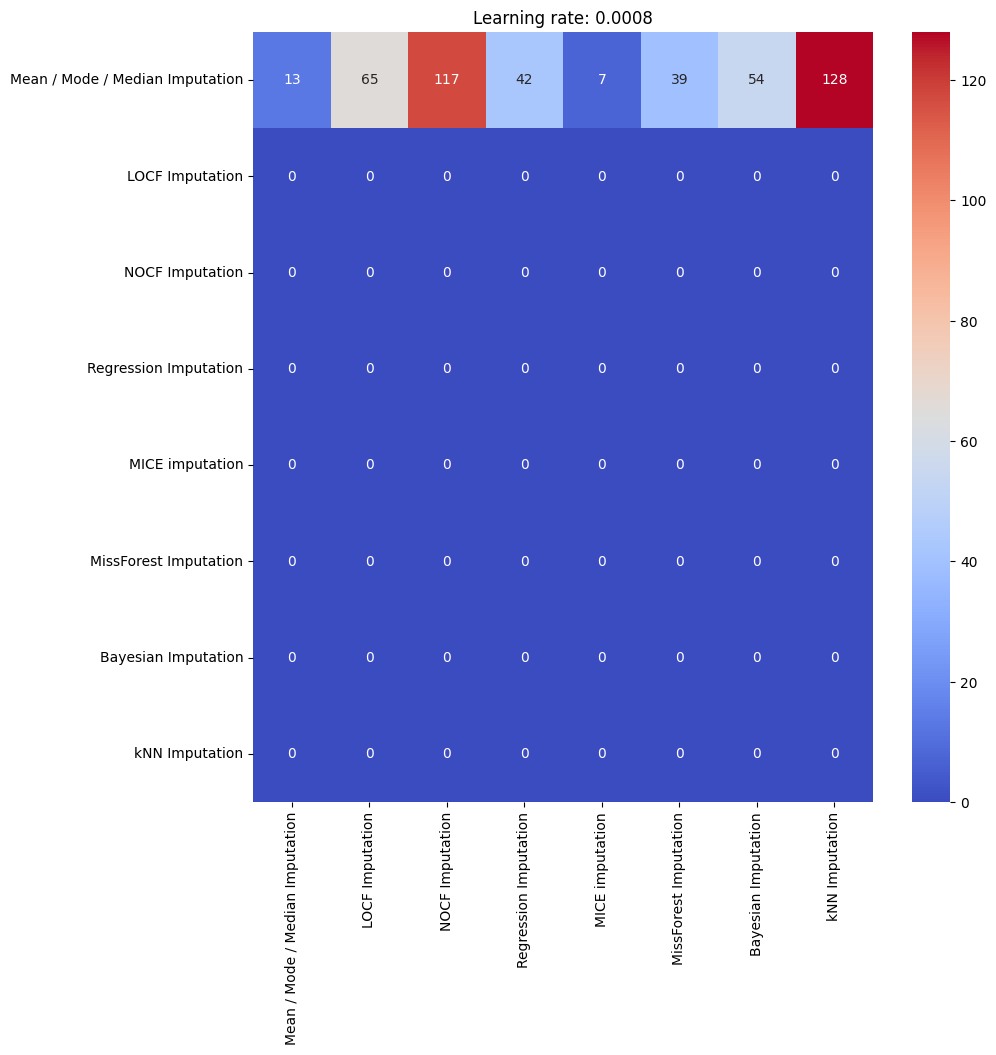

<Figure size 640x480 with 0 Axes>

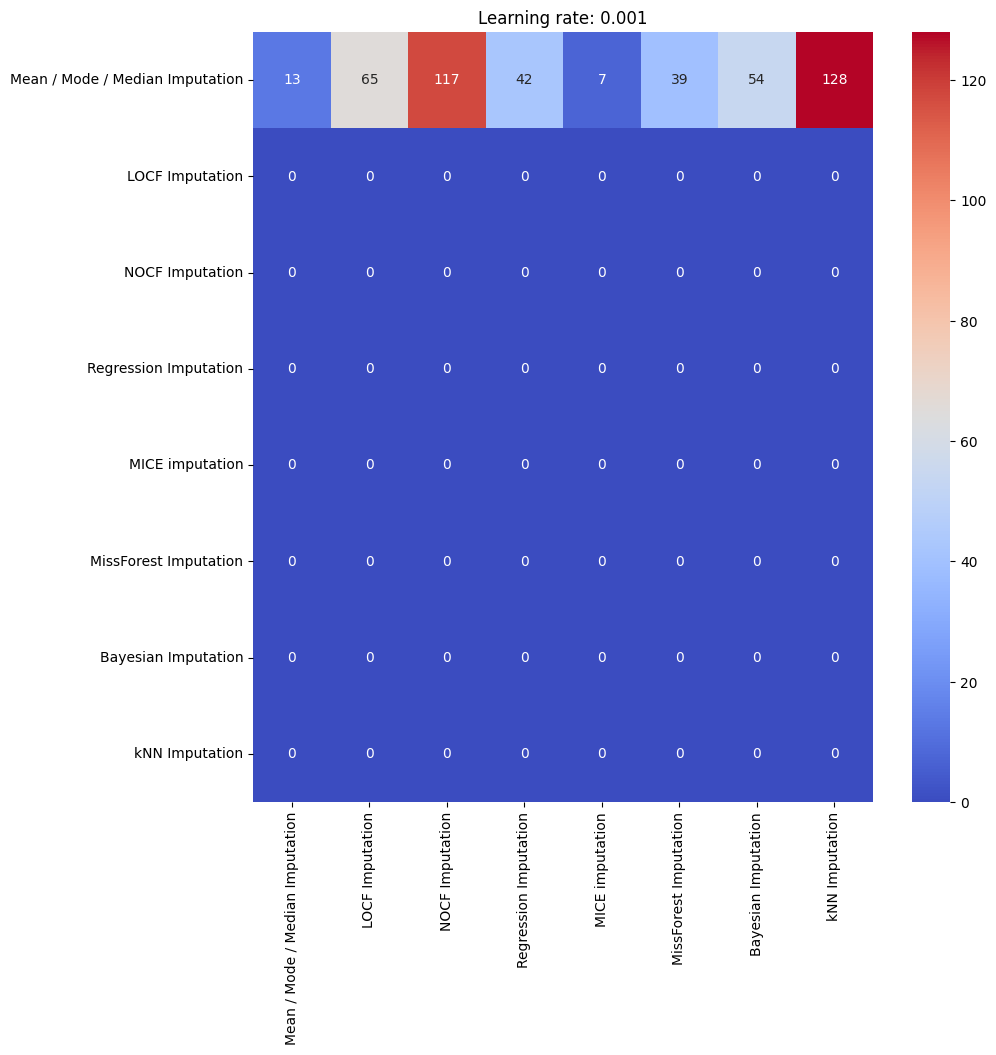

<Figure size 640x480 with 0 Axes>

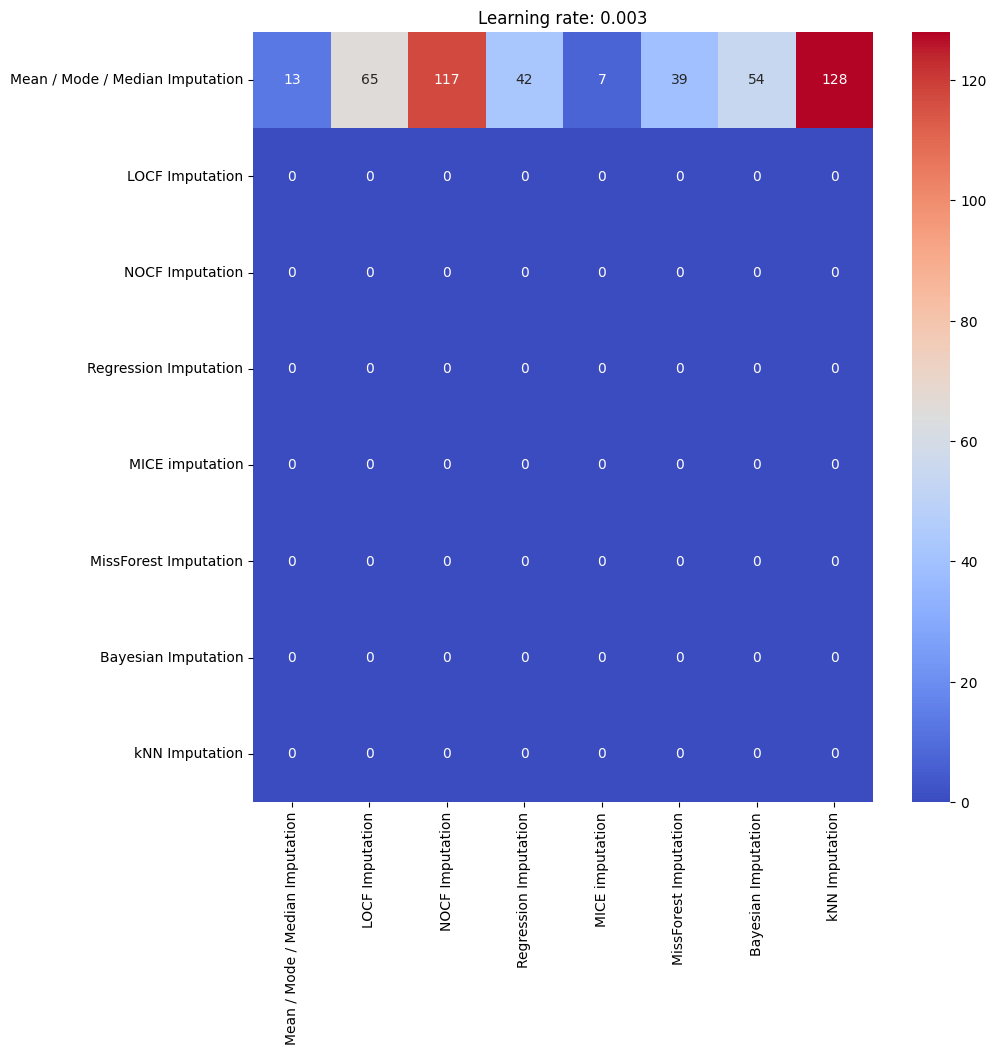

<Figure size 640x480 with 0 Axes>

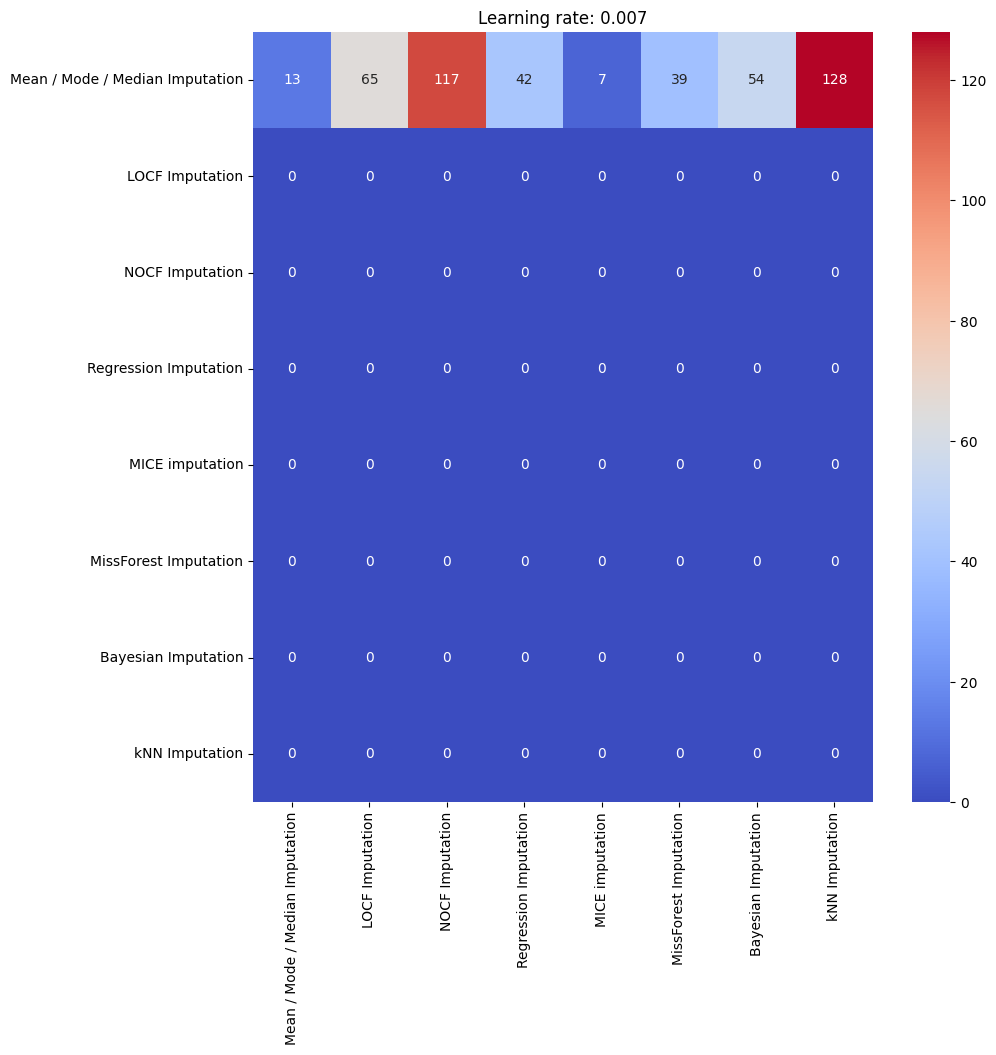

<Figure size 640x480 with 0 Axes>

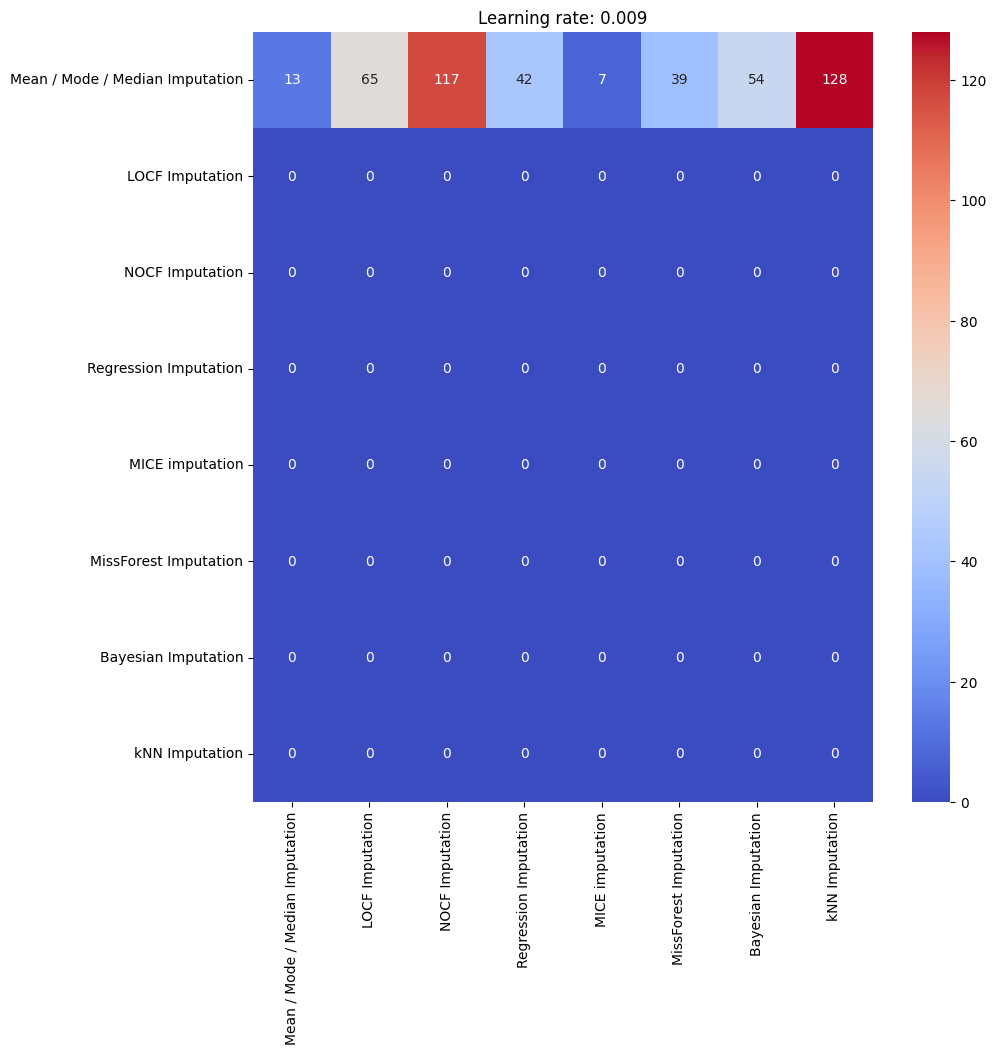

<Figure size 640x480 with 0 Axes>

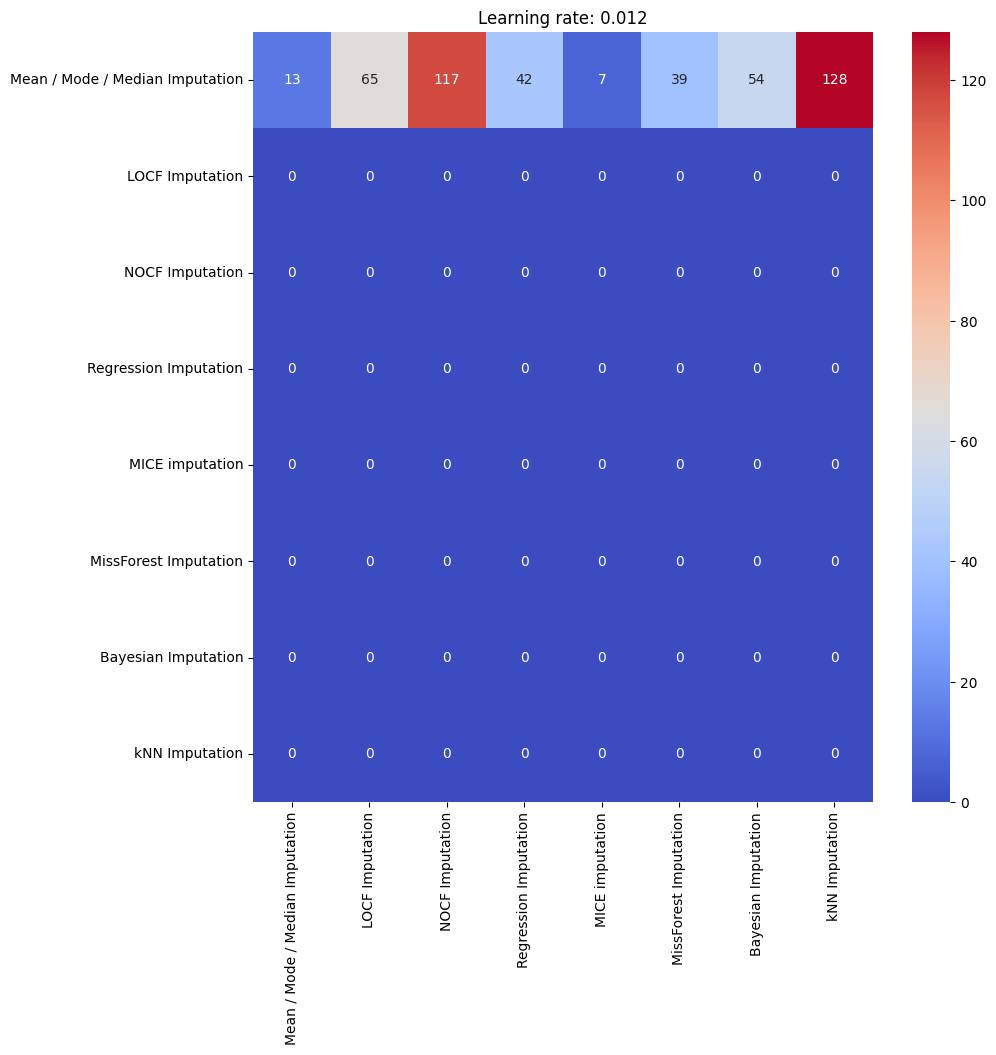

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 3 - Learning rate tunning

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, experiment3_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, learning_rates_labels, "Learning Rate", os.path.join(machine_learning_folder, experiment3_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, learning_rates_labels, "Learning rates training accuracy", os.path.join(machine_learning_folder, experiment3_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, learning_rates_labels, "Learning rates validation accuracy", os.path.join(machine_learning_folder, experiment3_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, experiment3_image_folder), validation_data, class_names, learning_rates_labels, os.path.join(machine_learning_folder, experiment3_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, experiment3_image_folder), [(validation_data[0], validation_data[1])], class_names, learning_rates_labels, os.path.join(machine_learning_folder, experiment3_stats_folder))

#### Results - Learning rate tunning

This experiments have shown that whilst the different learning rates affect the shape of the curve at the intial point they mostly occupy the same space. All have a stable convergence to the same point.

#### Adjust model parameters - Learning rate tunning

In [ ]:
# Initialise parameters again

# Set new learning rate - 0.005 from 0.005
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)


# Previous model save = "experiement2_model_stats/iteration4_model_stats.csv"

## Experiment 4 - Batch size tunning

In this experiment we adjust the Batch size in an attempt to optimise the model. In the current state the model the model is not learning to distinguish between imputation algorithms and always converges to chossing between one or two without exception. This could be due to the class imbalanace and low batch size meaning most batches only contain one or two types of classess which they use to learn

#### Variable initialisation - Batch size tunning

In [ ]:
# Variable initalisation for experiment 4 - Batch size tunning
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")
prev_experiment_label = f"Current Model - Batch size: {batch_size}"

# Set the learning rates to be tested
batch_sizes = [4, 16, 32, 64]
batch_sizes_labels = [f"Batch size: {batch_size}" for batch_size in batch_sizes] + [prev_experiment_label]

# Set folders for the saving of stats, models and figures
experiment4_stats_folder = "experiement4_model_stats"
experiment4_image_folder = "experiement4_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, experiment4_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment4_stats_folder))
    print(f"Folder '{experiment4_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, experiment4_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment4_image_folder))
    print(f"Folder '{experiment4_image_folder}' created.")

#### Running experiment - Batch size tunning

In [ ]:
# Running the code for experiment 4 - Batch size tunning


# Run experiment, looping through the batch_sizes:
for index in range(0, len(batch_sizes)):
  print("\n\n----------------------------------------------------------------------------", f"Running iteration {str(index+1)}: Batch size: {str(batch_sizes[index])}")

  # Enable egear execution
  tf.compat.v1.enable_eager_execution()

  batch_size = batch_sizes[index] # Get the batch size

  # Get the inital data needed for training
  train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

  # Use current iteration save spaces to configure callbacks
  current_iteration_callbacks = configure_callbacks(
      model_stats_save_file = os.path.join(machine_learning_folder, experiment4_stats_folder, f"iteration{str(index+1)}_model_stats.csv"),
      model_image_save_file = os.path.join(machine_learning_folder, experiment4_image_folder, f"iteration{str(index+1)}_model_image.keras")
  )

  # Initalise model and callbacks with default parameters
  optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
  model = configure_model(
      learning_rate = learning_rate,
      classes = num_classes,
      loss_function = loss_function,
      optimizer = optimizer,
      initializer = initializer,
      dropout_rate = dropout_rate,
      extra_layer_switches = extra_layer_switches,
      has_augment = has_augment,
      augment_prob = augment_prob
  )

  if is_datasets:
    history = model.fit(
        train_data,
        validation_data = validation_data,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )

  else:
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data = (validation_data[0], validation_data[1]),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )



---------------------------------------------------------------------------- Running iteration 1: Batch size: 4
Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2697 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 2/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2859 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2827 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2717 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2737 - loss: nan - val_a

#### Analyse experiment - Batch size tunning

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539


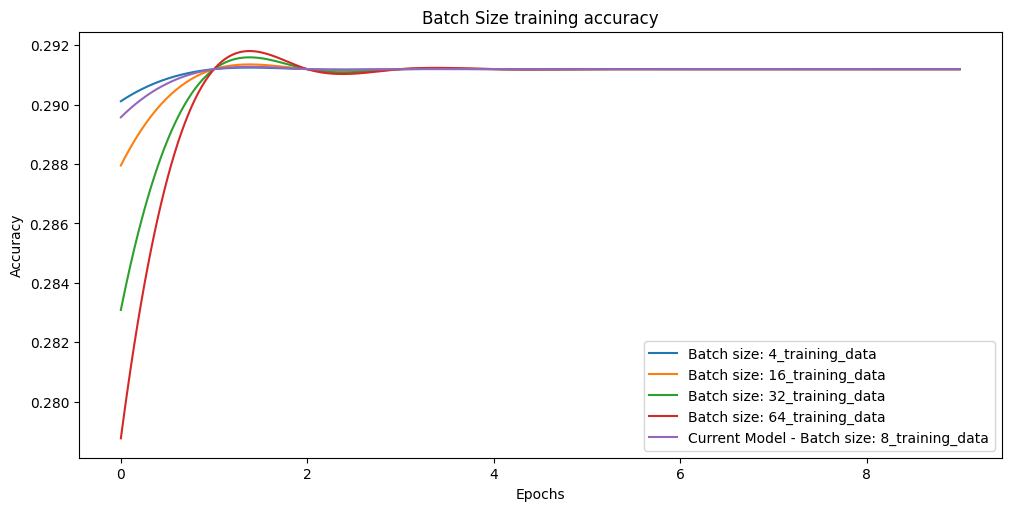

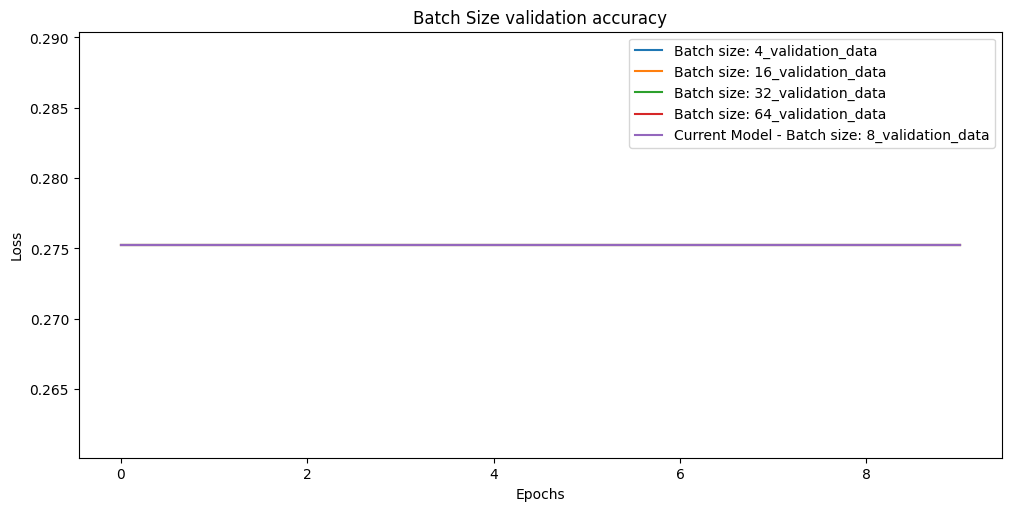

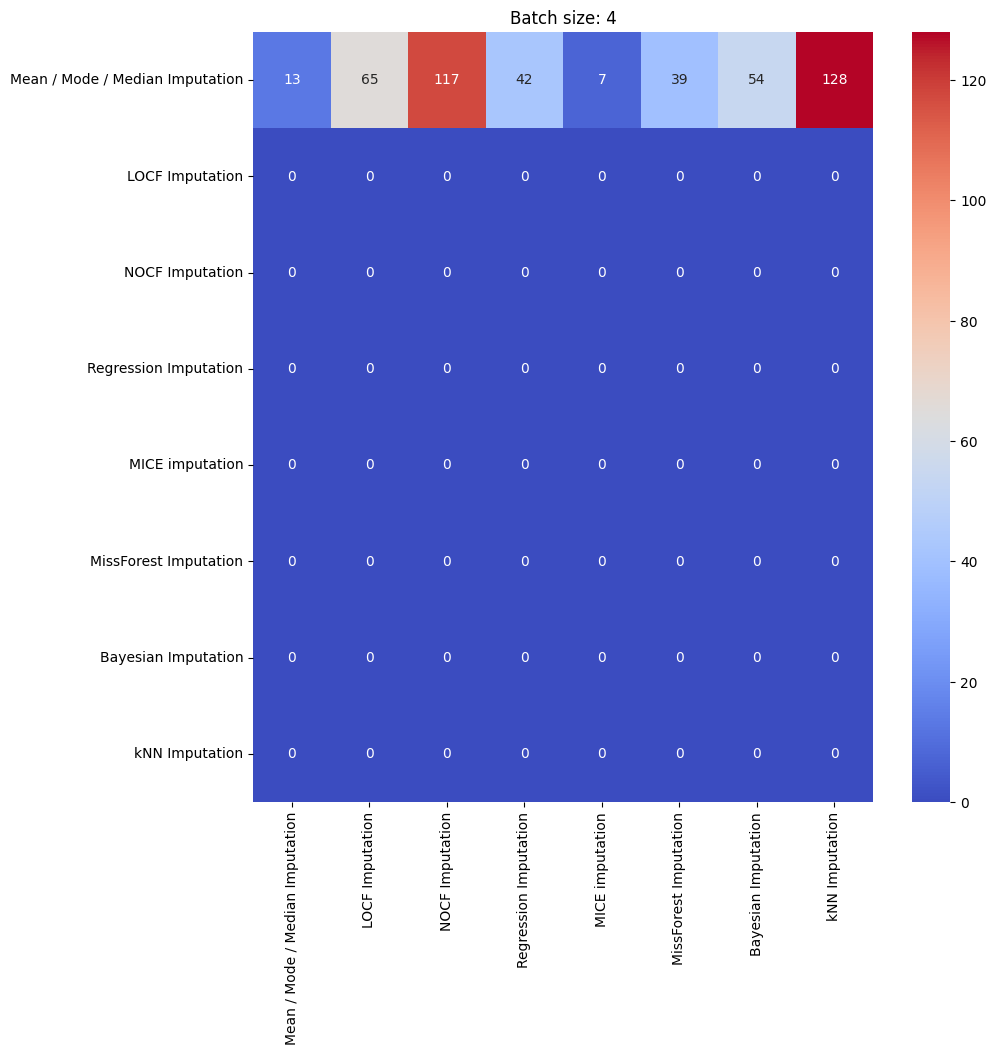

<Figure size 640x480 with 0 Axes>

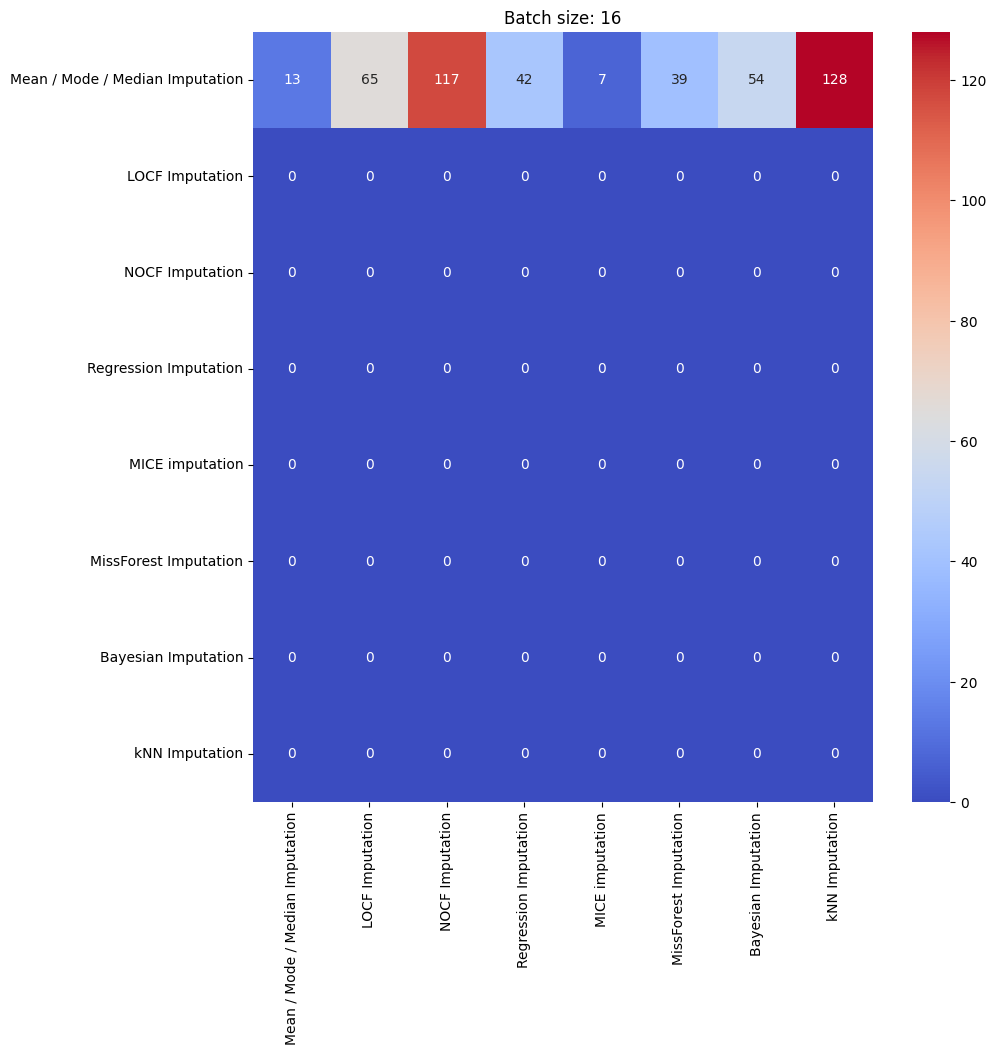

<Figure size 640x480 with 0 Axes>

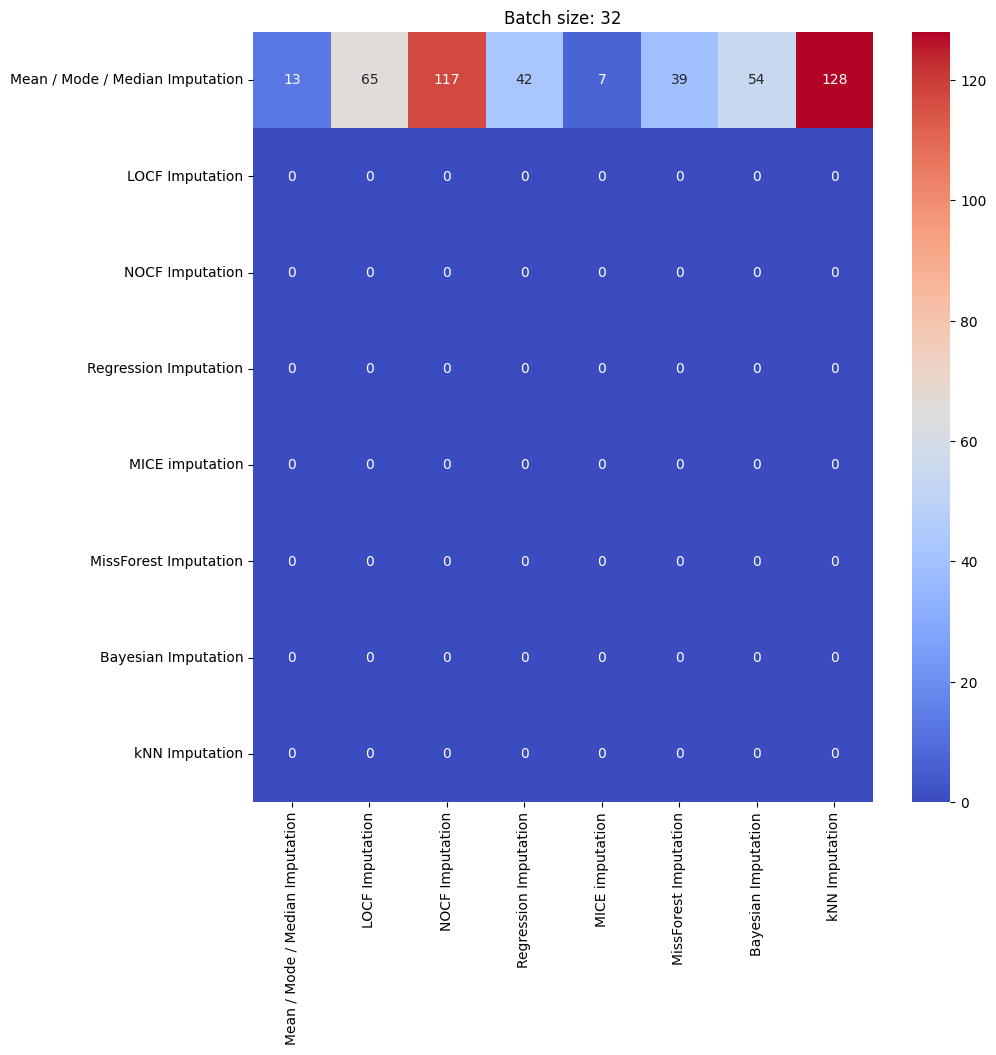

<Figure size 640x480 with 0 Axes>

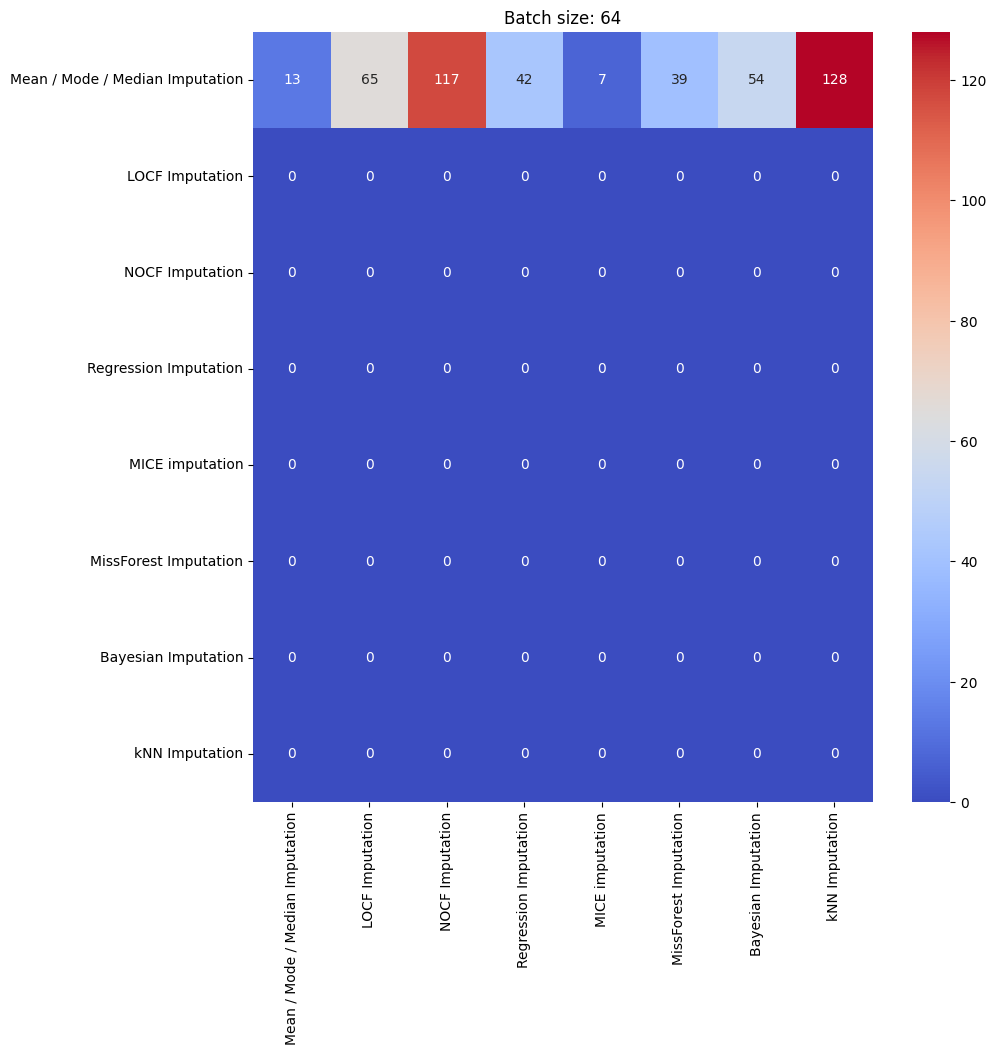

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 4 - Batch size tunning

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, experiment4_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, batch_sizes_labels, "Batch Size", os.path.join(machine_learning_folder, experiment4_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, batch_sizes_labels, "Batch Size training accuracy", os.path.join(machine_learning_folder, experiment4_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, batch_sizes_labels, "Batch Size validation accuracy", os.path.join(machine_learning_folder, experiment4_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, experiment4_image_folder), validation_data, class_names, batch_sizes_labels, os.path.join(machine_learning_folder, experiment4_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, experiment4_image_folder), [(validation_data[0], validation_data[1])], class_names, batch_sizes_labels, os.path.join(machine_learning_folder, experiment4_stats_folder))


#### Results - Batch size tunning

This experiments have shown that whilst the different batch sizes affect the shape of the curve at the intial point they mostly occupy the same space. All have a stable convergence to the same point.

#### Adjust model parameters - Batch size tunning

In [ ]:
# Initialise parameters again

# Set new batch size - 8 from 8
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)


# Previous model save = "first_experiment1_stats_folder/iteration1_model_stats.csv"

## Experiment 5 - Utilising different initialisers

In this experiment we switch out the initialisers in the hope that despite the models learning being volatile it puts it into a better starting positions to learn

#### Variable initialisation - Utilising different initialisers

In [ ]:
# Variable initalisation for experiment 5 - Utilising different initialisers
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")
prev_experiment_label = f"Current Model - Initialiser: GlorotUniform"

# Initialise initialisers list
initializers = [HeNormal(seed=0), RandomNormal(seed=0)]
initializers_names = ["HeNormal", "RandomNormal"] + [prev_experiment_label]

# Set folders for the saving of stats, models and figures
experiment5_stats_folder = "experiement5_model_stats"
experiment5_image_folder = "experiement5_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, experiment5_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment5_stats_folder))
    print(f"Folder '{experiment5_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, experiment5_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment5_image_folder))
    print(f"Folder '{experiment5_image_folder}' created.")

#### Running experiment - Utilising different initialisers

In [ ]:
# Running the code for experiment 5 - Utilising different initialisers


# Run experiment, looping through the initializers:
for index in range(0, len(initializers)):
  print("\n\n----------------------------------------------------------------------------", f"Running iteration {str(index+1)}: Initializer: {str(initializers_names[index])}")

  # Enable egear execution
  tf.compat.v1.enable_eager_execution()

  initializer = initializers[index] # Get the initializer

  # Get the inital data needed for training
  train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

  # Use current iteration save spaces to configure callbacks
  current_iteration_callbacks = configure_callbacks(
      model_stats_save_file = os.path.join(machine_learning_folder, experiment5_stats_folder, f"iteration{str(index+1)}_model_stats.csv"),
      model_image_save_file = os.path.join(machine_learning_folder, experiment5_image_folder, f"iteration{str(index+1)}_model_image.keras")
  )

  # Initalise model and callbacks with default parameters
  optimizer=SGD(learning_rate=learning_rate) # optimiser needs to be reset every time the model is trained
  model = configure_model(
      learning_rate = learning_rate,
      classes = num_classes,
      loss_function = loss_function,
      optimizer = optimizer,
      initializer = initializer,
      dropout_rate = dropout_rate,
      extra_layer_switches = extra_layer_switches,
      has_augment = has_augment,
      augment_prob = augment_prob
  )

  if is_datasets:
    history = model.fit(
        train_data,
        validation_data = validation_data,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )

  else:
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data = (validation_data[0], validation_data[1]),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )



---------------------------------------------------------------------------- Running iteration 1: Initializer: HeNormal
Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2724 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2845 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2701 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2855 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2836 - loss: na

#### Analyse experiment - Utilising different initialisers

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539


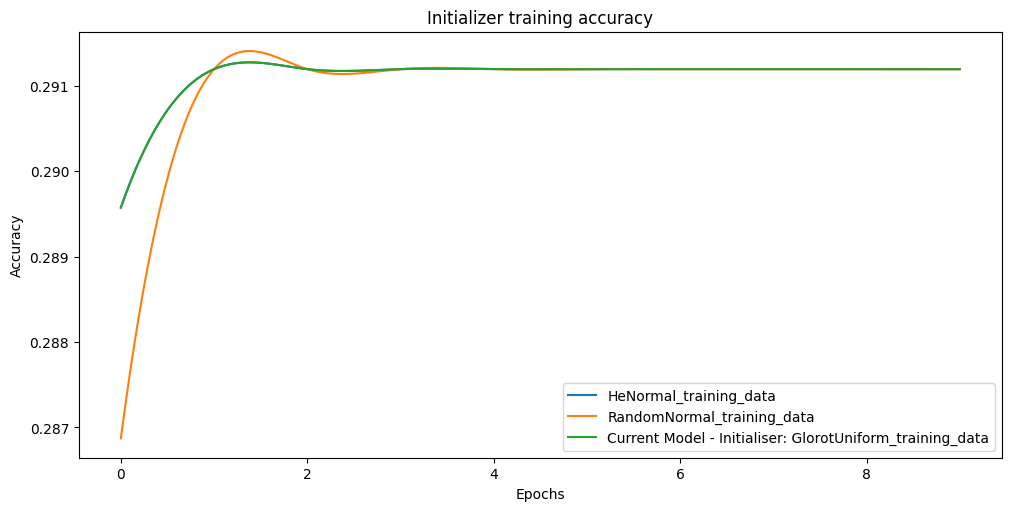

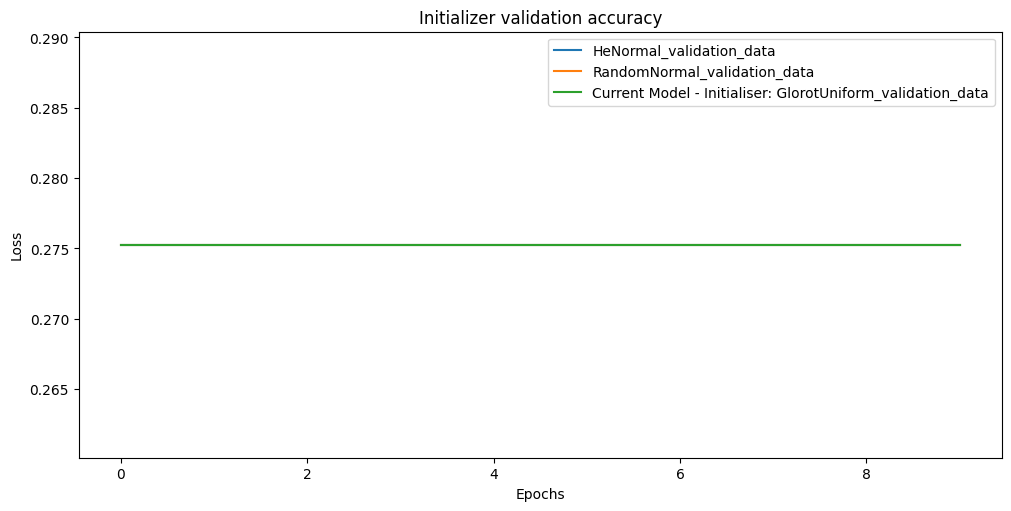

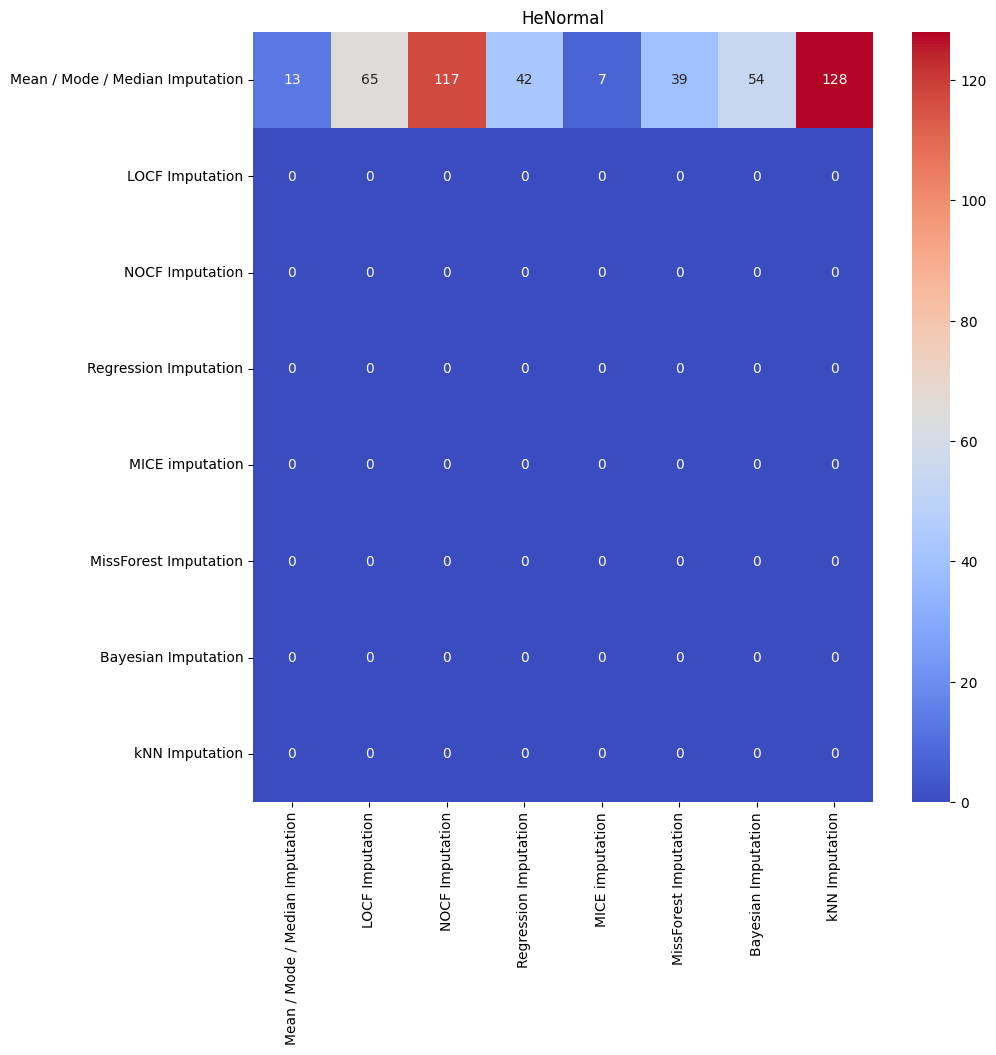

<Figure size 640x480 with 0 Axes>

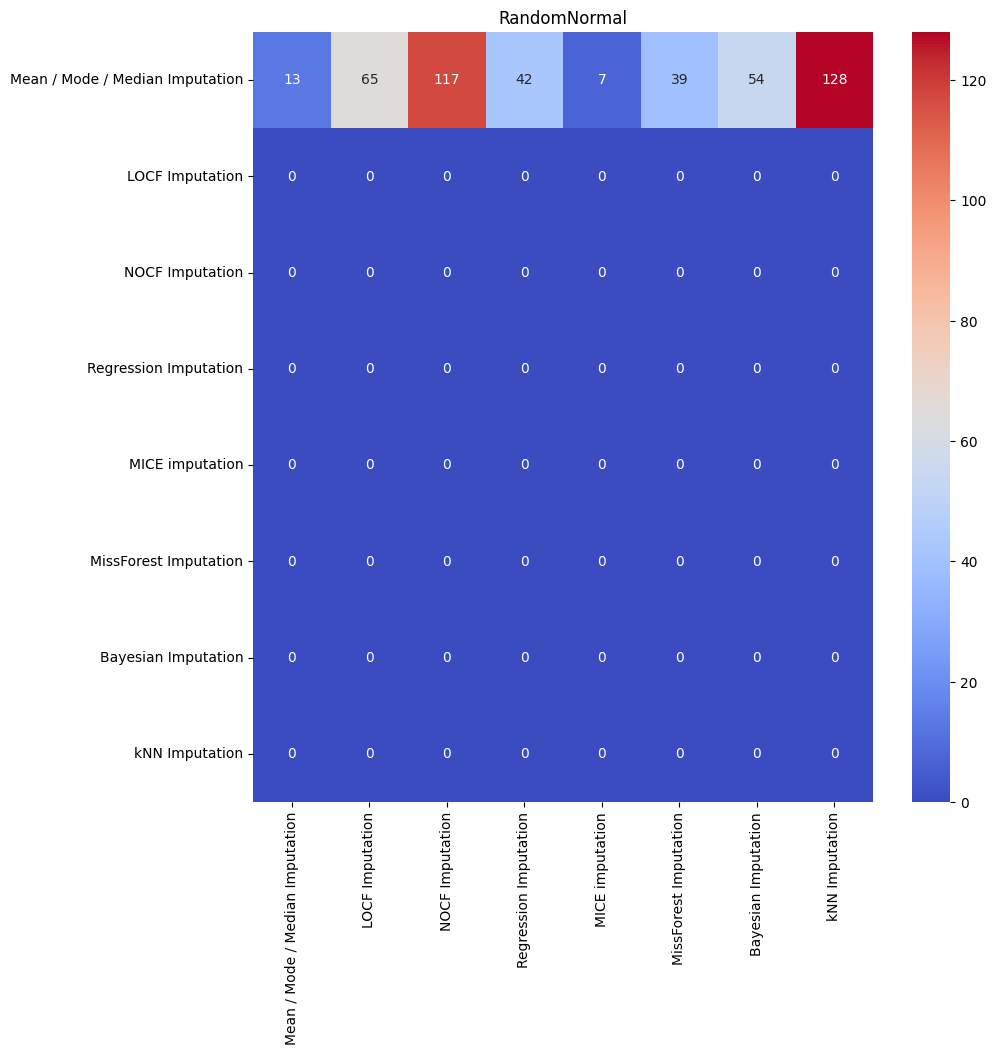

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 5 - Utilising different initialisers

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, experiment5_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, initializers_names, "Initializer", os.path.join(machine_learning_folder, experiment5_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, initializers_names, "Initializer training accuracy", os.path.join(machine_learning_folder, experiment5_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, initializers_names, "Initializer validation accuracy", os.path.join(machine_learning_folder, experiment5_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, experiment5_image_folder), validation_data, class_names, initializers_names, os.path.join(machine_learning_folder, experiment5_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, experiment5_image_folder), [(validation_data[0], validation_data[1])], class_names, initializers_names, os.path.join(machine_learning_folder, experiment5_stats_folder))


#### Results - Utilising different initialisers

This experiments have shown that whilst the initialisers affect the shape of the curve at the intial point they mostly occupy the same space. All have a stable convergence to the same point.

#### Adjust model parameters - Utilising different initialisers

In [ ]:
# Initialise parameters again

# Set new initialiser - GlorotUniform from GlorotUniform
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)


# Previous model save = "first_experiment1_stats_folder/iteration1_model_stats.csv"

## Experiment 6 - Utilising different optimiser

In this experiment we switch out the optimisers in the hope that the model will learn better under a different optimiser

#### Variable initialisation - Utilising different optimiser

In [ ]:
# Variable initalisation for experiment 6 - Utilising different optimiser
prev_experiment_stats_file = os.path.join(machine_learning_folder, first_experiment1_stats_folder, "iteration1_model_stats.csv")
prev_experiment_label = f"Current Model - Initialiser: SDG"

# Initialise initialisers list
optimizers = [Adam(learning_rate=learning_rate), AdamW(learning_rate=learning_rate)]
optimizers_names = ["Adam", "AdamW"] + [prev_experiment_label]

# Set folders for the saving of stats, models and figures
experiment6_stats_folder = "experiement6_model_stats"
experiment6_image_folder = "experiement6_model_image"


# Create folders if they don't exist
if not os.path.exists(os.path.join(machine_learning_folder, experiment6_stats_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment6_stats_folder))
    print(f"Folder '{experiment6_stats_folder}' created.")


if not os.path.exists(os.path.join(machine_learning_folder, experiment6_image_folder)):
    os.makedirs(os.path.join(machine_learning_folder, experiment6_image_folder))
    print(f"Folder '{experiment6_image_folder}' created.")

#### Running experiment - Utilising different optimiser

In [ ]:
# Running the code for experiment 6 - Utilising different optimiser


# Run experiment, looping through the optimizers:
for index in range(0, len(optimizers)):
  print("\n\n----------------------------------------------------------------------------", f"Running iteration {str(index+1)}: Optimizer: {str(optimizers_names[index])}")

  # Enable egear execution
  tf.compat.v1.enable_eager_execution()

  # Get the inital data needed for training
  train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)

  # Use current iteration save spaces to configure callbacks
  current_iteration_callbacks = configure_callbacks(
      model_stats_save_file = os.path.join(machine_learning_folder, experiment6_stats_folder, f"iteration{str(index+1)}_model_stats.csv"),
      model_image_save_file = os.path.join(machine_learning_folder, experiment6_image_folder, f"iteration{str(index+1)}_model_image.keras")
  )

  # Initalise model and callbacks with default parameters
  optimizer=optimizers[index] # optimiser needs to be reset every time the model is trained
  model = configure_model(
      learning_rate = learning_rate,
      classes = num_classes,
      loss_function = loss_function,
      optimizer = optimizer,
      initializer = initializer,
      dropout_rate = dropout_rate,
      extra_layer_switches = extra_layer_switches,
      has_augment = has_augment,
      augment_prob = augment_prob
  )

  if is_datasets:
    history = model.fit(
        train_data,
        validation_data = validation_data,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )

  else:
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data = (validation_data[0], validation_data[1]),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = current_iteration_callbacks,
        verbose=1,
        class_weight = class_weight_dict
    )



---------------------------------------------------------------------------- Running iteration 1: Optimizer: Adam
Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.1150 - loss: 299777442971648.0000 - val_accuracy: 0.2452 - val_loss: 2012403204096.0000
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1736 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2703 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2845 - loss: nan - val_accuracy: 0.2753 - val_loss: nan
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - a

#### Analyse experiment - Utilising different optimiser

Value: Bayesian Imputation, Count: 267
Value: LOCF Imputation, Count: 246
Value: MICE imputation, Count: 31
Value: Mean / Mode / Median Imputation, Count: 55
Value: MissForest Imputation, Count: 98
Value: NOCF Imputation, Count: 437
Value: Regression Imputation, Count: 178
Value: kNN Imputation, Count: 539


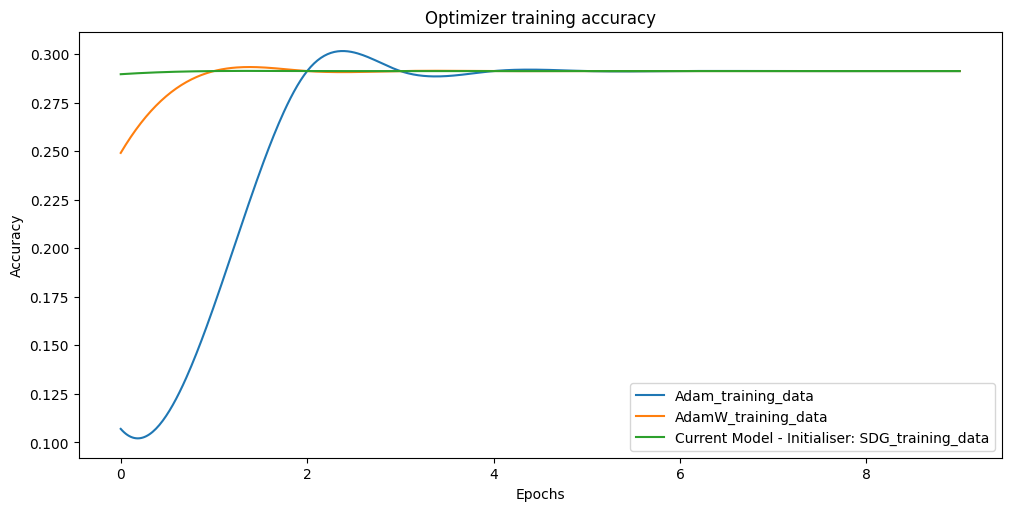

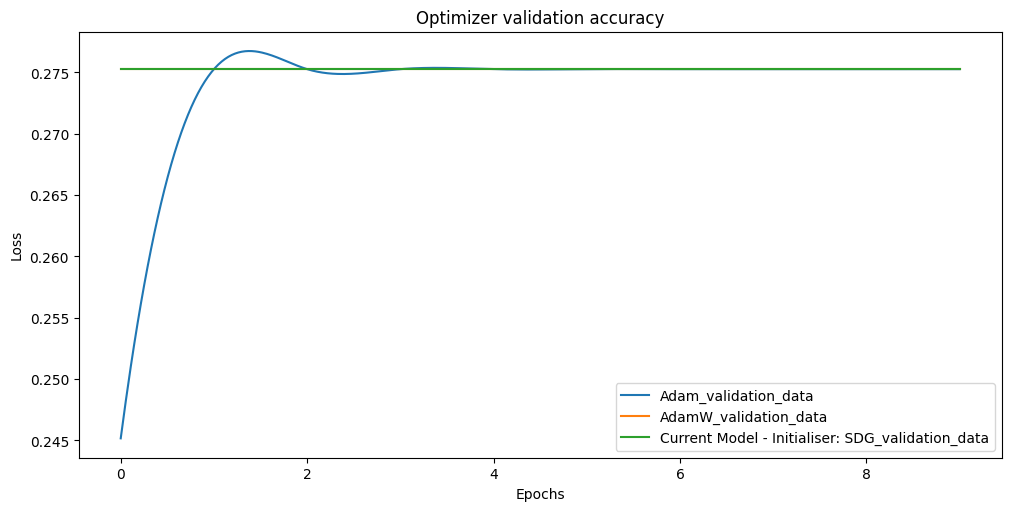

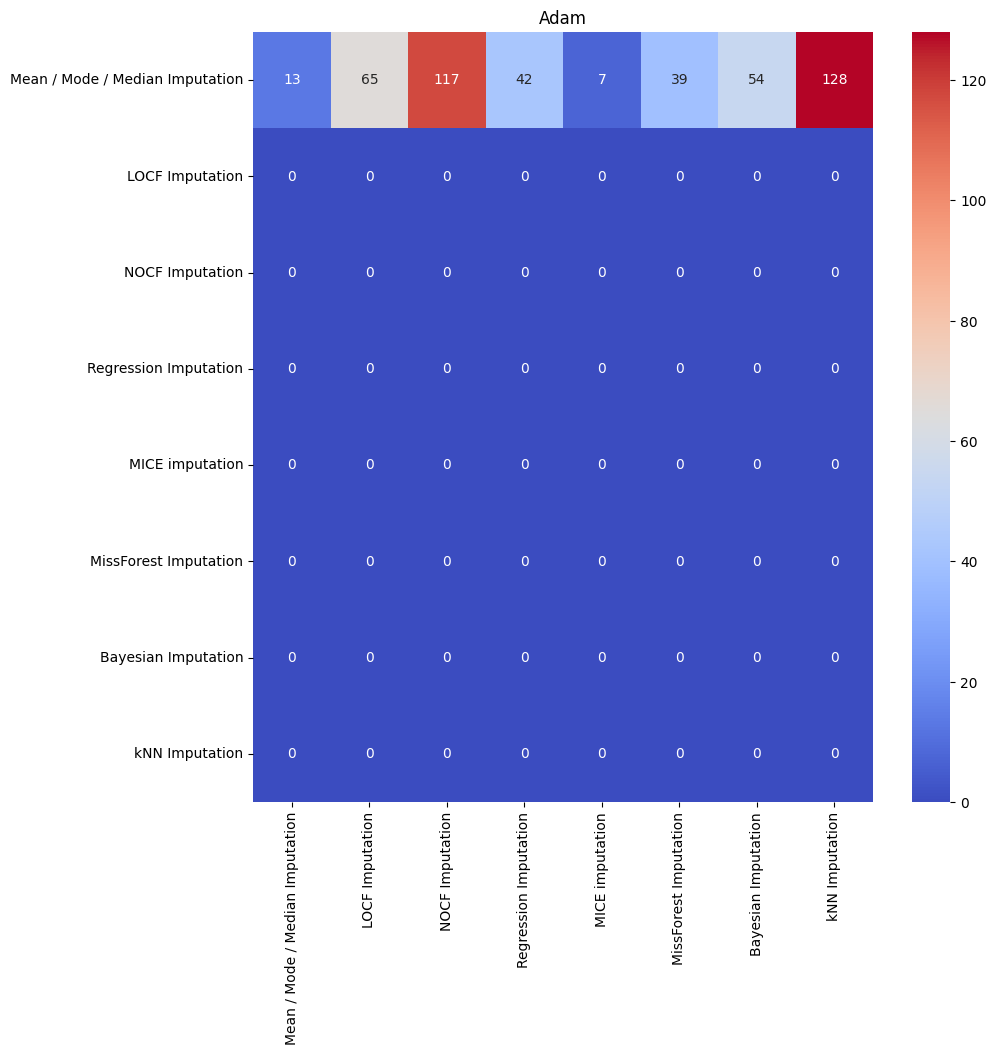

<Figure size 640x480 with 0 Axes>

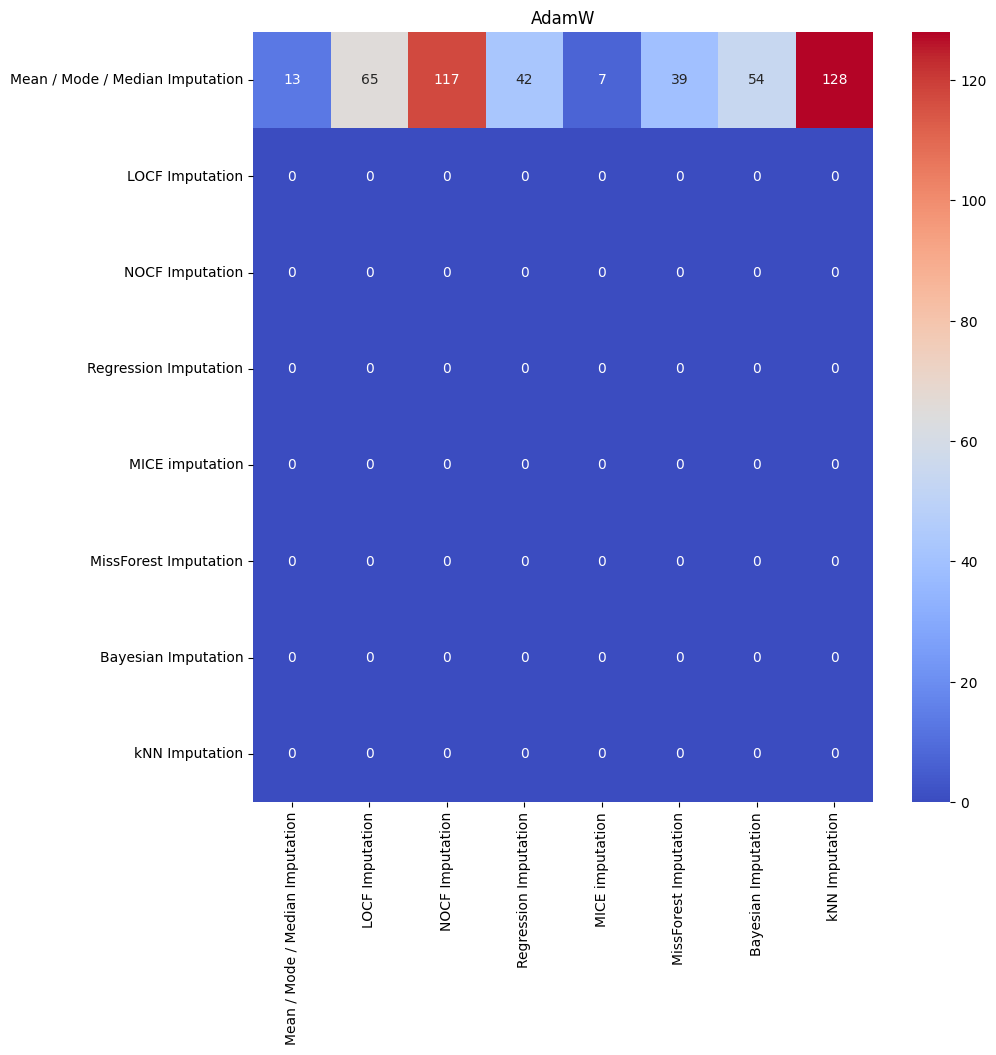

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analysis code for experiment 6 - Utilising different optimiser

# Make sure validation data is set so the confusion matrix can be loaded
train_data, validation_data, class_weight_dict = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, num_classes, is_datasets, batch_size)


# Get all csv files with the previous experiments
iteration_data = get_csv_files(os.path.join(machine_learning_folder, experiment6_stats_folder), prev_experiment_stats_file)


# Create table of stats for each iteration at their final epoch
graph_iterations_final_stats(iteration_data, optimizers_names, "Optimizer", os.path.join(machine_learning_folder, experiment6_stats_folder), epochs)

# Run training sets analysis for accuracy
graph_trainingData_iteration_accuracy_comparison(iteration_data, optimizers_names, "Optimizer training accuracy", os.path.join(machine_learning_folder, experiment6_stats_folder))

# Run validation sets analysis for accuracy
graph_validationData_iteration_accuracy_comparison(iteration_data, optimizers_names, "Optimizer validation accuracy", os.path.join(machine_learning_folder, experiment6_stats_folder))


# Apply confusion matrix analysis
if(is_datasets):
  load_keras_confusion(os.path.join(machine_learning_folder, experiment6_image_folder), validation_data, class_names, optimizers_names, os.path.join(machine_learning_folder, experiment6_stats_folder))
else:
  load_keras_confusion(os.path.join(machine_learning_folder, experiment6_image_folder), [(validation_data[0], validation_data[1])], class_names, optimizers_names, os.path.join(machine_learning_folder, experiment6_stats_folder))


#### Results - Utilising different optimiser

This experiments have shown that whilst the optimisers affect the shape of the curve at the intial point they mostly occupy the same space. All have a stable convergence to the same point.

#### Adjust model parameters - Utilising different optimiser

In [ ]:
# Initialise parameters again

# Set new optimiser - SGD from SGD
learning_rate = 0.005
loss_function = CategoricalCrossentropy()
optimizer = SGD(learning_rate=learning_rate)
initializer = GlorotUniform(seed=0)
dropout_rate = 0.99
extra_layer_switches = [False, False, False, False, False]
has_augment = False
augment_prob = 0
batch_size = 8
epochs = 10
num_input = 40
num_classes = len(class_names)


# Previous model save = "first_experiment1_stats_folder/iteration1_model_stats.csv"

# **Conclusion**

In these experiments to optimise a neural network to reccomend the "optimal" imputation algorithms many options have been exauhested with complete failure to move the model past its original validation accuracy no matter how the parameters of the model are adjusted including the size or architecture. We are left to conclude that this isn't the right model for this problem as it either requires a network that needs much more data to train properly or simply isn't the right kind of model for this problem